# WikiRecs Part 2 - Modeling and Evaluation
> In this second part of the two part series, we will handle the modeling and evaluation side. We will load the saved artifacts and train 7 implicit recommender models. We will compare the performance using various evaluation metrics. We will also visualize the embeddings.

- toc: true
- badges: true
- comments: true
- categories: [Evaluation, Visualization, Implicit, GridSearch, Resurface]
- author: "<a href='https://github.com/drsaunders/wikirecs'>Daniel Saunders</a>"
- image:

## Setup

In [ ]:
!git clone https://github.com/sparsh-ai/reco-wikirecs
%cd /content/reco-wikirecs/
!pip install -r requirements.txt

!pip install -q git+https://github.com/sparsh-ai/recochef.git

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from scipy.sparse import csr_matrix, csc_matrix, lil_matrix, coo_matrix

from recochef.datasets.wikirecs import WikiRecs

import implicit
from implicit.nearest_neighbours import bm25_weight
from implicit.nearest_neighbours import BM25Recommender

from utils import *
from wiki_pull import *
from recommenders import *

In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Loading artifacts

In [ ]:
p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t = load_pickle('lookup_tables.pickle')
userids, pageids = load_pickle('users_and_pages.pickle')
resurface_userids, discovery_userids = load_pickle('resurface_discovery_users.pickle')
implicit_matrix = load_pickle('implicit_matrix.pickle')

## Test the matrix and indices

In [ ]:
# Crude item to item recs by looking for items edited by the same editors (count how many editors overlap)
veditors = np.flatnonzero(implicit_matrix[t2i['Hamburger'],:].toarray())
indices =  np.flatnonzero(np.sum(implicit_matrix[:,veditors] > 0,axis=1))
totals = np.asarray(np.sum(implicit_matrix[:,veditors] > 0 ,axis=1)[indices])
sorted_order = np.argsort(totals.squeeze())

[i2t.get(i, "")  + " " + str(total[0]) for i,total in zip(indices[sorted_order],totals[sorted_order])][::-1][:10]

['Hamburger 10',
 'Hemp 3',
 'Poetry 3',
 'Korean War 3',
 'Michael Jackson 3',
 'Borat Subsequent Moviefilm 3',
 'Elon Musk 3',
 'Stand-up comedy 3',
 'Greater Mexico City 2',
 'Asymmetric warfare 2']

## Baseline models

| Model | Type | Description |
| - | -:| ---:|
| Popularity | Rule-based | Most popular over the past year |
| Recent | Rule-based | Most recently edited by this user |
| Frequent | Rule-based | Most frequently edited by this user in the last year |
| BM25 | Collaborative-filtering | Okapi BM25, a simple variation on Jaccard similarity with TF-IDF that often has much better results |
| ALS | Collaborative-filtering | Alternating Least Squares matrix factorization of implicit training data, with BM25 pre-scaling |

## Implicit recommendation

In [ ]:
implicit_matrix = load_pickle('implicit_matrix_2021-05-28.pickle')
p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t = load_pickle('lookup_tables_2021-05-28.pickle')

In [ ]:
bm25_matrix = bm25_weight(implicit_matrix, K1=100, B=0.25)

In [ ]:
num_factors =200
regularization = 0.01
os.environ["OPENBLAS_NUM_THREADS"] = "1"
model = implicit.als.AlternatingLeastSquares(
    factors=num_factors, regularization=regularization
)
model.fit(bm25_matrix)

  0%|          | 0/15 [00:00<?, ?it/s]

In [ ]:
save_pickle(model,'als%d_bm25_model.pickle' % num_factors)

In [ ]:
model = wr.load_pickle('als200_bm25_model_2021-05-28.pickle')

In [ ]:
results = model.similar_items(t2i['Steven Universe'],20)
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['Steven Universe 1.0000',
 'She-Ra and the Princesses of Power 0.8897',
 'Stevonnie 0.8331',
 'Infinity Train 0.8052',
 'The Dragon Prince 0.7930',
 'Kipo and the Age of Wonderbeasts 0.7746',
 'Adult animation 0.7707',
 'The Legend of Korra 0.7689',
 'Steven Universe (character) 0.7685',
 'Athena Karkanis 0.7661',
 'SuperFuckers 0.7660',
 "MatPat's Game Lab 0.7654",
 'List of webcomics with LGBT characters 0.7645',
 'Tangled: Before Ever After 0.7632',
 'List of cross-dressing characters in animated series 0.7621',
 'Andrew Wells 0.7607',
 "Rhett & Link's Buddy System 0.7581",
 'Q-Force (TV series) 0.7568',
 'Cleopatra in Space (TV series) 0.7565',
 'Olan Rogers 0.7561']

In [ ]:
u = n2u["Rama"]
recommendations = model.recommend(u2i[u], bm25_matrix.tocsc(), N=1000, filter_already_liked_items=False)
[ ("*" if implicit_matrix[ind,u2i[u]]>0 else "") +
'%s %.4f' % (i2t[ind], score) + ' %d' % (implicit_matrix[ind,:]>0).sum()
 for ind, score in recommendations]

### Grid search results

In [ ]:
grid_search_results = wr.load_pickle("implicit_grid_search.pickle")

In [ ]:
pd.DataFrame(grid_search_results)

,num_factors,regularization,metrics,time
0,250,0.001,"{'recall': 6.721069930862518, 'ndcg': 0.034484...",3001.013066
1,250,0.010,"{'recall': 6.641731837243568, 'ndcg': 0.034212...",2910.232232
2,250,0.100,"{'recall': 6.5737277569987524, 'ndcg': 0.03360...",2820.923943
3,500,0.001,"{'recall': 8.568514110846651, 'ndcg': 0.044450...",5764.793829
4,500,0.010,"{'recall': 8.62518417771733, 'ndcg': 0.0441560...",5783.447170
5,500,0.100,"{'recall': 8.500510030601836, 'ndcg': 0.044005...",5776.124852


In [ ]:
pd.DataFrame([[i['num_factors'], i['regularization']] + list(i['metrics'].values()) for i in grid_search_results],
            columns = ['num_factors','regularization'] + list(grid_search_results[0]['metrics'].keys()))

,num_factors,regularization,recall,ndcg,resurfaced,recall_discover,recall_resurface,ndcg_discover,ndcg_resurface
0,250,0.001,6.721070,0.034485,23.744758,0.951526,16.600061,0.003516,0.087512
1,250,0.010,6.641732,0.034212,23.709056,0.987433,16.323394,0.003592,0.086641
2,250,0.100,6.573728,0.033609,23.545279,0.951526,16.200430,0.003505,0.085154
3,500,0.001,8.568514,0.044451,31.403151,0.969479,21.580080,0.003511,0.114551
4,500,0.010,8.625184,0.044156,31.375949,0.969479,21.733784,0.003492,0.113784
5,500,0.100,8.500510,0.044006,31.216140,0.933573,21.457117,0.003349,0.113621


In [ ]:
grid_search_results_bm25 = wr.load_pickle("implicit_grid_search_bm25.pickle")

In [ ]:
pd.DataFrame([[i['num_factors'], i['regularization']] + list(i['metrics'].values()) for i in grid_search_results_bm25],
            columns = ['num_factors','regularization'] + list(grid_search_results_bm25[0]['metrics'].keys()))

,num_factors,regularization,recall,ndcg,resurfaced,recall_discover,recall_resurface,ndcg_discover,ndcg_resurface
0,50,0.001,3.796894,0.017984,12.258302,0.664273,9.160775,0.002499,0.044498
1,50,0.010,3.751558,0.018032,12.269636,0.646320,9.068552,0.002504,0.044621
2,50,0.100,3.638218,0.017705,12.154596,0.592460,8.853366,0.002439,0.043843
3,100,0.001,4.907628,0.024072,16.589029,0.736086,12.050415,0.002850,0.060410
4,100,0.010,4.884960,0.023839,16.515924,0.736086,11.988933,0.002792,0.059878
5,100,0.100,4.862292,0.023483,16.418452,0.754039,11.896711,0.002734,0.059009
6,200,0.001,6.199705,0.031379,21.681401,0.879713,15.308946,0.003416,0.079258
7,200,0.010,6.279043,0.031622,21.674600,0.933573,15.431909,0.003481,0.079808
8,200,0.100,6.109033,0.031209,21.474555,0.879713,15.063019,0.003278,0.079034


## B25 Recommendation

/Users/dsaunder/WikiRecs/venvs/wikirecs/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:>

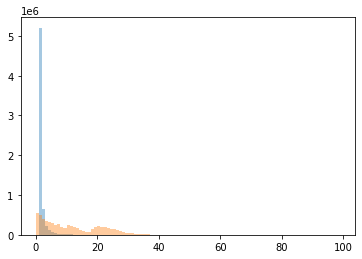

In [ ]:
bm25_matrix = bm25_weight(implicit_matrix, K1=20, B=1)
bm25_matrix = bm25_matrix.tocsc()
sns.distplot(implicit_matrix[implicit_matrix.nonzero()],bins = np.arange(0,100,1),kde=False)

sns.distplot(bm25_matrix[bm25_matrix.nonzero()],bins = np.arange(0,100,1),kde=False)

In [ ]:
K1 = 100
B = 0.25
model = BM25Recommender(K1, B)
model.fit(implicit_matrix)

  0%|          | 0/2955960 [00:00<?, ?it/s]

In [ ]:
save_pickle(model, 'bm25_model_2021-05-28.pkl')

In [ ]:
results = model.similar_items(t2i['Mark Hamill'],20)
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['Steve Jobs 477.7697',
 'Dwane Wallace 150.9094',
 'Klapmeier brothers 150.6235',
 'Collier Trophy 148.3838',
 'Steve Wozniak 147.1619',
 'Cirrus VK-30 144.7877',
 'Jony Ive 144.6390',
 'Living Legends of Aviation 144.3238',
 'Bob Hoover 140.9139',
 'Duluth, Minnesota 139.5445',
 'Richard VanGrunsven 139.4321',
 'Paul Allen 138.5211',
 'List of aerospace engineers 132.4959',
 'Wright brothers 127.7536',
 'Bill Lear 127.6163',
 'Harrison Ford 123.7455',
 'Steve Fossett 123.5423',
 'University of Chicago sit-ins 122.8748',
 'List of people from Duluth, Minnesota 122.8440',
 'General aviation 122.6389']

In [ ]:
a = ['Steven Universe 429.4746',
 'List of Steven Universe episodes 178.4544',
 'Demon Bear 128.7237',
 'Legion of Super Heroes (TV series) 128.7237',
 'The Amazing World of Gumball 126.3522',
 'Steven Universe Future 123.9198']

In [ ]:
results = model.similar_items(t2i['Steven Universe'],20)
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['Steven Universe 429.4746',
 'List of Steven Universe episodes 178.4544',
 'Demon Bear 128.7237',
 'Legion of Super Heroes (TV series) 128.7237',
 'The Amazing World of Gumball 126.3522',
 'Steven Universe Future 123.9198',
 'Say Uncle (Steven Universe) 122.4732',
 'We Bare Bears 120.9546',
 'Infinity Train 118.2566',
 'List of programs broadcast by Cartoon Network 116.1771',
 'The Transformers (TV series) 115.4370',
 "Bucky O'Hare and the Toad Wars 111.7774",
 'Alex Hirsch 111.1865',
 'Michaela Dietz 107.4665',
 'Sage (comics) 106.2310',
 'X-Men: Evolution 106.2310',
 'Unikitty! 104.4489',
 'Elliott from Earth 103.1397',
 'The Dark Knight Returns 101.2090',
 'Action figure 101.2090']

In [ ]:
results = model.similar_items(t2i['George Clooney'],20)
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['George Clooney 397.5589',
 'Leonardo DiCaprio 107.9109',
 'Matt Damon 104.0771',
 'The Ides of March (2011 film) 97.0278',
 'Ryan Gosling 95.8138',
 'Ben Affleck 92.0652',
 'French Montana 89.1391',
 'The Town (2010 film) 89.0408',
 'Tilda Swinton 88.5061',
 'Drake (musician) 88.0232',
 'The Firm (1993 film) 87.0600',
 'Emily Mortimer 86.4226',
 'Jacqueline Bisset 83.9981',
 'Pulp Fiction 82.5731',
 'Alessandro Nivola 82.5252',
 'Sergeant at Arms of the United States House of Representatives 82.2913',
 'Jarin Blaschke 81.8214',
 'Lincoln High School (Lincoln, Nebraska) 81.8181',
 'Pasta maker 81.8181',
 'Spires Boling 81.8181']

In [ ]:
results = model.similar_items(t2i['Hamburger'],20)
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['Hamburger 353.7146',
 'Big Mac 127.4685',
 'Liver and onions 102.0406',
 "Potatoes O'Brien 102.0406",
 'Louisiana Creole cuisine 97.8882',
 'Long John (doughnut) 96.9773',
 'Hostess CupCake 96.9773',
 'Pizza 95.4866',
 'Designation of workers by collar color 91.1759',
 'North Korean cuisine 88.2469',
 'Hash (food) 86.8303',
 'Baghaar-e-baingan 84.2800',
 'Agent Orange (cocktail) 84.2800',
 'Grasshopper pie 84.2800',
 'Tibooburra, New South Wales 84.2321',
 'Lonkero 84.2010',
 'Taaborinvuori 84.0466',
 'Father 83.5346',
 'Sandwiches de miga 81.9828',
 'Ham salad 81.9828']

In [ ]:
u = n2u["Rama"]
recommendations = model.recommend(u2i[u], implicit_matrix.astype(np.float32), N=1000, filter_already_liked_items=True)

In [ ]:
[ ("*" if implicit_matrix[ind,u2i[u]]>0 else "") +
'%s %.4f' % (i2t[ind], score) 
 for ind, score in recommendations]

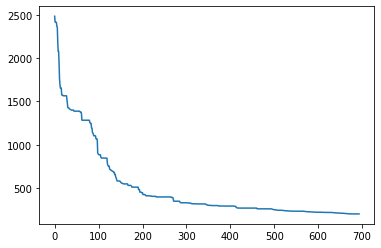

In [ ]:
plt.plot([ score for i,(ind, score) in enumerate(recommendations) if implicit_matrix[ind,u2i[u]]==0])

In [ ]:
save_pickle(model, "b25_model.pickle")

In [ ]:
model = load_pickle("b25_model.pickle")

## Evaluate models

### Item to item recommendation

In [ ]:
results = model.similar_items(t2i['Steven Universe'],20)
['%s %.4f' % (i2t[ind], score) for ind, score in results]

['Steven Universe 1.0000',
 'List of She-Ra and the Princesses of Power episodes 0.9472',
 "To All the Boys I've Loved Before (film series) 0.9200",
 'List of Our Cartoon President episodes 0.9175',
 'Buddi 0.9168',
 'Talking with Chris Hardwick 0.9167',
 'List of Wacky Races (2017 TV series) episodes 0.9167',
 'Pacific Heat 0.9083',
 'Kiznaiver 0.9039',
 'List of Vampirina episodes 0.8999',
 'List of Ben 10: Ultimate Alien episodes 0.8917',
 '3Below: Tales of Arcadia 0.8840',
 'List of Dorothy and the Wizard of Oz episodes 0.8812',
 'List of Bakugan: Battle Planet episodes 0.8743',
 'List of The Tom and Jerry Show (2014 TV series) episodes 0.8738',
 'Adventure Time: Distant Lands 0.8704',
 'List of Steven Universe episodes 0.8692',
 'The Cleveland Show (season 1) 0.8632',
 'Skylanders Academy 0.8623',
 'List of Guardians of the Galaxy episodes 0.8620']

### User to item recommendations

In [ ]:
# Check out a specific example

u = n2u["HyprMarc"]

print_user_history(clean_histories, userid=u)

2020-06-12
 01:59:50 Black Widow (Natasha Romanova)
 02:01:30 Vision (Marvel Comics)
 02:06:58 Loki (Marvel Cinematic Universe)
 02:08:03 Heimdall (comics)
 02:10:28 Ebony Maw
 02:12:04 Black Dwarf (comics)
 02:12:53 Proxima Midnight
 02:14:21 Corvus Glaive
 02:15:22 Proxima Midnight
 02:17:25 Black Dwarf (comics)
 02:18:42 Ebony Maw
 02:19:29 Black Dwarf (comics)
 11:08:14 Quicksilver (comics)
 11:35:03 Cosmic Cube
 11:37:46 Yondu
 11:47:11 Drax the Destroyer
 11:51:36 Carol Danvers
 12:03:58 Hela (comics)
 12:13:42 Ancient One
 12:15:24 Loki (comics)
 15:51:43 Ronan the Accuser
 15:59:43 Apocalypse (comics)
 16:02:49 Beyonder
2020-06-14
 07:15:45 Starfox (comics)
 11:47:16 Beyonder
 12:12:18 List of gemstones by species
 12:13:17 Grandidierite
 12:24:23 List of gemstones by species
2020-06-15
 05:39:01 Time dilation
 08:13:41 Silicon carbide
 08:24:59 Hope Diamond
2020-06-16
 01:30:41 Ronan the Accuser
 01:32:38 Superhuman strength
 04:18:02 Diamond
 06:26:00 White torture
 09:00:15 

In [ ]:
u = n2u["HyprMarc"]
recommendations = model.recommend(u2i[u], implicit_matrix, N=100, filter_already_liked_items=False)

In [ ]:
[ ("*" if implicit_matrix[ind,u2i[u]]>0 else "") +
'%s %.4f' % (i2t[ind], score) 
 for ind, score in recommendations]

## Visualize implicit embeddings

In [ ]:
model = load_pickle('als150_model.pickle')

In [ ]:
# Only plot the ones with over 3 entries
indices = np.squeeze(np.asarray(np.sum(implicit_matrix[nonzero,:],axis=1))) > 3

indices = nonzero[indices]

In [ ]:
len(indices)

21658

In [ ]:
# Visualize  the collaborative filtering item vectors, embedding into 2D space with UMAP
# nonzero = np.flatnonzero(implicit_matrix.sum(axis=1))
# indices = nonzero[::100]
embedding = umap.UMAP().fit_transform(model.item_factors[indices,:])

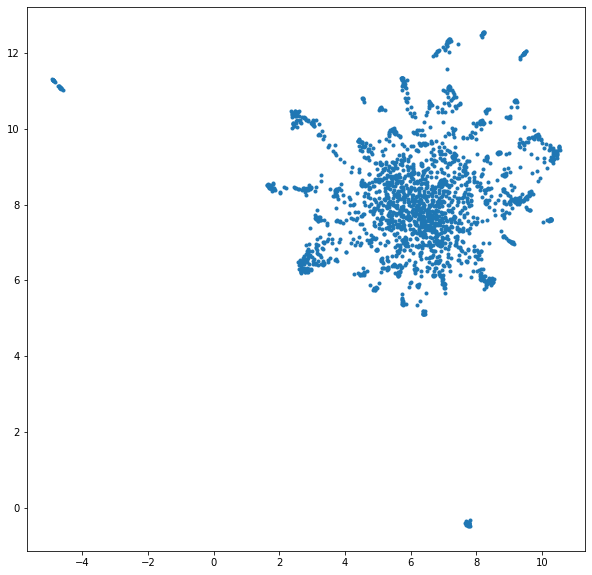

In [ ]:
plt.figure(figsize=(10,10))
plt.plot(embedding[:,0], embedding[:,1],'.')
# _ = plt.axis('square')

### Visualize actors in the embeddings space

In [ ]:
edit_counts = np.squeeze(np.asarray(np.sum(implicit_matrix[indices,:],axis=1)))
log_edit_counts = np.log10(np.squeeze(np.asarray(np.sum(implicit_matrix[indices,:],axis=1))))

emb_df = pd.DataFrame({'dim1':embedding[:,0].squeeze(), 
                       'dim2':embedding[:,1].squeeze(),
                       'title':[i2t[i] for i in indices],
                       'edit_count':edit_counts,
                       'log_edit_count':log_edit_counts
                       })

In [ ]:
actors = ['Mark Hamill',
'Carrie Fisher',
'James Earl Jones',
'David Prowse',
'Sebastian Shaw (actor)',
'Alec Guinness',
'Jake Lloyd',
'Hayden Christensen',
'Ewan McGregor',
'William Shatner',
'Leonard Nimoy',
'DeForest Kelley',
'James Doohan',
'George Takei']
actor_indices = [t2i[a] for a in actors]
edit_counts = np.squeeze(np.asarray(np.sum(implicit_matrix[actor_indices,:],axis=1)))
log_edit_counts = np.log10(np.squeeze(np.asarray(np.sum(implicit_matrix[actor_indices,:],axis=1))))
embedding = umap.UMAP().fit_transform(model.item_factors[actor_indices,:])
emb_df = pd.DataFrame({'dim1':embedding[:,0].squeeze(), 
                       'dim2':embedding[:,1].squeeze(),
                       'title':[i2t[i] for i in actor_indices],
                       'edit_count':edit_counts,
                       'log_edit_count':log_edit_counts
                       })
key = np.zeros(len(actors))
key[:8] = 1
fig = px.scatter(data_frame=emb_df,
                 x='dim1',
                 y='dim2', 
                 hover_name='title',
                 color=key,
                 hover_data=['edit_count'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600,)
fig.show()

In [ ]:
# Full embedding plotly interactive visualization

emb_df = pd.DataFrame({'dim1':embedding[:,0].squeeze(), 
                       'dim2':embedding[:,1].squeeze(),
                       'title':[i2t[i] for i in indices],
                       'edit_count':edit_counts,
                       'log_edit_count':log_edit_counts
                       })

fig = px.scatter(data_frame=emb_df,
                 x='dim1',
                 y='dim2', 
                 hover_name='title',
                 color='log_edit_count',
                 hover_data=['edit_count'])
fig.update_layout(
    autosize=False,
    width=600,
    height=600,)
fig.show()

## Evaluate on test set

In [ ]:
# Load the edit histories in the training set and the test set
histories_train = feather.read_feather('histories_train_2021-05-28.feather')
histories_test = feather.read_feather('histories_test_2021-05-28.feather')
histories_dev = feather.read_feather('histories_dev_2021-05-28.feather')

implicit_matrix = wr.load_pickle('implicit_matrix_2021-05-28.pickle')
p2t, t2p, u2n, n2u, p2i, u2i, i2p, i2u, n2i, t2i, i2n, i2t = wr.load_pickle('lookup_tables_2021-05-28.pickle')

userids, pageids = wr.load_pickle('users_and_pages_2021-05-28.pickle')

resurface_userids, discovery_userids   = wr.load_pickle('resurface_discovery_users_2021-05-28.pickle')

results = {}

In [ ]:
display_recs_with_history(
    recs,
    userids[:100],
    histories_test,
    histories_train,
    p2t,
    u2n,
    recs_to_display=5,
    hist_to_display=10,
)

,AxelBoldt,Berek,RobLa,LA2,Shsilver,Rmhermen,Ray Van De Walker,SimonP,Maury Markowitz,ASchoenhofer,...,SchmuckyTheCat,Meelar,Auric,Gidonb,ClemRutter,Caknuck,Bkell,Paul G,Mervyn,Sheridan
True value,Ulm Minster,Exterior calculus,Civil Rights Act of 1964,Flax,David Britton,"Paradise, Kentucky",IPHWR-700,St. Frances Cabrini Church (New Orleans),Plessey AR-320,Facility location (competitive game),...,List of politicians of Chinese descent,Maino De Maineri,Kavya Madhavan,Arabs in the Netherlands,Goodwin Academy,"List of Pro Bowl players, A",History of Pennsylvania,Diwakar Vaish,Manhattan Transfer (novel),Lego Star Wars
Rec 1,Girolamo Savonarola,2020 Bangladesh Election Commission scandal,Civil Rights Act of 1964,Elmer William Engstrom,Jorie Remus,Ade (drink suffix),Carl Icahn,Oblate Youth Australia,Plessey AR-3D,Flying Bulgar Klezmer Band,...,List of politicians of Chinese descent,Alec Baldwin,COVID-19 pandemic lockdown in India,Chris Arlman,Goodwin Academy,"List of Pro Bowl players, B",Pennsylvania Canal,Poorvi Koutish,Geographical indications and traditional speci...,Open-pit mining
Rec 2,CoronaVac,Kepler-533,Student Nonviolent Coordinating Committee,Sidney Low,Leonard B. Stern,Here Comes Santa Claus,Motorola,Nepsa,1948 Airborne Transport DC-3 disappearance,The Terminator,...,Windows 7,Central Park,Hongqi (marque),Claudia Florentino,Bob Burden (academic),"List of Pro Bowl players, C–F",New Orleans (steamboat),Eric Jokisch,Operation Brock,"Northgate High School, Ipswich"
Rec 3,Blackbird (land yacht),Next Indian general election in Gujarat,Leesburg Stockade,Living Lutheran,List of Worldcons,General Tso's chicken,Universal asynchronous receiver-transmitter,Giovanni Mossi,Micralign,Active users,...,Noah,Strip club,Water security,Kyrylo Kryvoborodenko,Thinking Schools Academy Trust,"List of Pro Bowl players, G–H",Buger,Robert M. Schoch,Juan García Esquivel,Comparison of Star Trek and Star Wars
Rec 4,Allium ursinum,Madhava Varma II,John Lewis,Esperance Stonehenge,Mata Hari,Remilitarization of the Rhineland,Phalanx,Mehrshahr,MOS Technology 6502,COVID-19 vaccine,...,List of time zones by country,Robert Rietti,Winged football helmet,KingFut,Holcombe Grammar School,"List of Pro Bowl players, I–K",Airplane!,List of Harry Potter cast members,Siamese cat,List of dams and reservoirs in the United Kingdom
Rec 5,Monocotyledon,Fairness for High Skilled Immigrants Act,West Seattle Bridge,Alice Tegnér,Galgano Guidotti,Popcorn chicken,Combined cycle power plant,Marv Albert Show,Fairchild 9440,Parasite (2019 film),...,Microsoft ergonomic keyboards,Nathan Barksdale,Yimakh shemo,Louis-Édouard Glackmeyer,Thinking School,"List of Pro Bowl players, L–M",Prison,Marjorie Welish,Claude Nicolas Ledoux,Wong Kei
-,----------,----------,----------,----------,----------,----------,----------,----------,----------,----------,...,----------,----------,----------,----------,----------,----------,----------,----------,----------,----------
Hist 1,Girolamo Savonarola,2020 Bangladesh Election Commission scandal,Civil Rights Act of 1964,Elmer William Engstrom,Jorie Remus,Ade (drink suffix),Carl Icahn,Oblate Youth Australia,Plessey AR-3D,Flying Bulgar Klezmer Band,...,List of politicians of Chinese descent,Alec Baldwin,COVID-19 pandemic lockdown in India,Chris Arlman,Goodwin Academy,"List of Pro Bowl players, B",Pennsylvania Canal,Poorvi Koutish,Geographical indications and traditional speci...,Open-pit mining
Hist 2,CoronaVac,Kepler-533,Student Nonviolent Coordinating Committee,Sidney Low,Jorie Remus,Here Comes Santa Claus,Motorola,Nepsa,1948 Airborne Transport DC-3 disappearance,The Terminator,...,List of politicians of Chinese descent,Central Park,Hongqi (marque),Chris Arlman,Goodwin Academy,"List of Pro Bowl players, C–F",New Orleans (steamboat),Eric Jokisch,Operation Brock,"Northgate High School, Ipswich"
Hist 3,Blackbird (land yacht),Kepler-533,Student Nonviolent Coordinating Committee,Living Lutheran,Leonard B. Stern,General Tso's chicken,Motorola,Giovanni Mossi,Mi

In [ ]:
import utils as wr
import numpy as np
from tqdm.auto import tqdm
import itertools
import pandas as pd
from implicit.nearest_neighbours import BM25Recommender


class Recommender(object):
    def __init__(self):
        raise NotImplementedError

    def recommend(self, userid=None, username=None, N=10):
        raise NotImplementedError

    def recommend_all(self, userids, num_recs, **kwargs):
        recs = {}
        with tqdm(total=len(userids), leave=True) as progress:
            for u in userids:
                recs[u] = self.recommend(userid=u, N=num_recs, **kwargs)
                progress.update(1)

        return recs


class PopularityRecommender(Recommender):
    def __init__(self, interactions):
        with wr.Timer("Building popularity table"):
            self.editors_per_page = (
                interactions.drop_duplicates(subset=["TITLE", "USER"])
                .groupby(["ITEMID", "TITLE"])
                .count()
                .USER.sort_values(ascending=False)
            )

    def recommend(self, N=10, userid=None, user=None):
        return self.editors_per_page.iloc[:N].index.get_level_values(0).values


class MostRecentRecommender(Recommender):
    """
    Recommend the most recently edited pages by the user in reverse chronological
    order. When those run out, go to most popular
    """

    def __init__(self, interactions):
        with wr.Timer("Building popularity table"):
            self.editors_per_page = (
                interactions.drop_duplicates(subset=["TITLE", "USER"])
                .groupby(["ITEMID", "TITLE"])
                .count()
                .USER.sort_values(ascending=False)
            )

    def all_recent_only(self, N=10, userids=None, interactions=None):
        recents = {}

        with tqdm(total=len(userids), leave=True) as progress:
            for u in userids:
                is_user_row = interactions.USERID == u
                recents[u] = (
                    interactions[is_user_row]
                    .drop_duplicates(subset=["ITEMID"])
                    .iloc[:N]
                    .ITEMID.values
                )
                progress.update(1)
        return recents

    def recommend(self, N=10, userid=None, user=None, interactions=None):
        if user is not None:
            is_user_row = interactions.user == user
        elif userid is not None:
            is_user_row = interactions.USERID == userid
        else:
            raise ValueError("Either user or userid must be non-null")

        deduped_pages = interactions[is_user_row].drop_duplicates(subset=["pageid"])
        if len(deduped_pages) == 1:
            recs = []
        else:
            # Don't take the most recent, because this dataset strips out repeated instance
            recs = deduped_pages.iloc[1:N].pageid.values

        # If we've run out of recs, fill the rest with the most popular entries
        if len(recs) < N:
            recs = np.concatenate(
                [
                    recs,
                    self.editors_per_page.iloc[: (N - len(recs))]
                    .index.get_level_values(0)
                    .values,
                ]
            )
        return recs


class MostFrequentRecommender(Recommender):
    """
    Recommend the most frequently edited pages by the user. When those run out, go to most popular
    """

    def __init__(self, interactions):
        with wr.Timer("Building popularity table"):
            self.editors_per_page = (
                interactions.drop_duplicates(subset=["TITLE", "USER"])
                .groupby(["pageid", "title"])
                .count()
                .USER.sort_values(ascending=False)
            )

    def recommend(self, N=10, userid=None, user=None, interactions=None):
        if user is not None:
            is_user_row = interactions.USER == user
        elif userid is not None:
            is_user_row = interactions.ITEMID == userid
        else:
            raise ValueError("Either user or userid must be non-null")

        recs = (
            interactions[is_user_row]
            .groupby("ITEMID")
            .USER.count()
            .sort_values(ascending=False)
            .index[:N]
            .values
        )

        # If we've run out of recs, fill the rest with the most popular entries
        if len(recs) < N:
            recs = np.concatenate(
                [
                    recs,
                    self.editors_per_page.iloc[: (N - len(recs))]
                    .index.get_level_values(0)
                    .values,
                ]
            )
        return recs


class ImplicitCollaborativeRecommender(Recommender):
    def __init__(self, model, implicit_matrix):
        self.model = model
        self.implicit_matrix = implicit_matrix

    def recommend(
        self,
        N=10,
        userid=None,
        user=None,
        u2i=None,
        n2i=None,
        i2p=None,
        filter_already_liked_items=False,
    ):
        if user is not None:
            user_index = n2i[user]
        elif userid is not None:
            user_index = u2i[userid]
        else:
            raise ValueError("Either user or userid must be non-null")

        recs_indices = self.model.recommend(
            user_index,
            self.implicit_matrix,
            N,
            filter_already_liked_items=filter_already_liked_items,
        )
        recs = [i2p[a[0]] for a in recs_indices]

        return recs

    def recommend_all(self, userids, num_recs, i2p, filter_already_liked_items=True):
        all_recs = self.model.recommend_all(
            self.implicit_matrix.T,
            num_recs,
            filter_already_liked_items=filter_already_liked_items,
        )
        recs = {
            userid: [i2p[i] for i in all_recs[i, :]] for i, userid in enumerate(userids)
        }

        return recs


class MyBM25Recommender(Recommender):
    def __init__(self, model, implicit_matrix):
        self.model = model

        self.implicit_matrix = implicit_matrix

    def recommend(
        self,
        N=10,
        filter_already_liked_items=True,
        userid=None,
        user=None,
        u2i=None,
        n2i=None,
        i2p=None,
    ):
        if user is not None:
            user_index = n2i[user]
        elif userid is not None:
            user_index = u2i[userid]
        else:
            raise ValueError("Either user or userid must be non-null")

        recs_indices = self.model.recommend(
            user_index,
            self.implicit_matrix.astype(np.float32),
            N,
            filter_already_liked_items=filter_already_liked_items,
        )
        recs = [i2p[a[0]] for a in recs_indices]

        if len(recs) <= 20:
            recs = recs + [recs[-1]] * (20 - len(recs))

        return recs


class JaccardRecommender(Recommender):
    def __init__(self, implicit_matrix, p2i, t2i, i2t, i2p, n2i, u2i, i2u):
        self.implicit_matrix = implicit_matrix
        self.p2i = p2i
        self.t2i = t2i
        self.i2t = i2t
        self.i2p = i2p
        self.n2i = n2i
        self.i2p = i2p
        self.u2i = u2i
        self.i2u = i2u

    def jaccard_multiple(self, page_indices, exclude_index=None):
        X = self.implicit_matrix.astype(bool).astype(int)
        if exclude_index is None:
            intrsct = X.dot(X[page_indices, :].T)
            totals = X[page_indices, :].sum(axis=1).T + X.sum(axis=1)
        else:
            use_indices = np.full(X.shape[1], True)
            use_indices[exclude_index] = False
            # print(X[:, use_indices].shape)
            # print(X[page_indices, :][:, use_indices].T.shape)

            intrsct = X[:, use_indices].dot(X[page_indices, :][:, use_indices].T)
            totals = X[page_indices, :][:, use_indices].sum(axis=1).T + X[
                :, use_indices
            ].sum(axis=1)

        return intrsct / (totals - intrsct)

    def recommend(
        self,
        N=10,
        userid=None,
        user=None,
        num_lookpage_pages=None,
        recent_pages_dict=None,
        interactions=None,
    ):
        if user is not None:
            user_index = self.n2i[user]
        elif userid is not None:
            user_index = self.u2i[userid]
        else:
            raise ValueError("Either user or userid must be non-null")

        recent_pages = recent_pages_dict[self.i2u[user_index]][:num_lookpage_pages]

        user_page_indices = [self.p2i[p] for p in recent_pages]
        d = self.jaccard_multiple(user_page_indices, exclude_index=user_index)

        d = np.nan_to_num(d)
        d[d == 1] = np.nan

        mean_jaccard = np.nanmean(d, axis=1).A.squeeze()
        order = np.argsort(mean_jaccard)[::-1]
        return [self.i2p[o] for o in order[:N]]

    def item_to_item(self, N=10, title=None, pageid=None):
        if title is not None:
            page_index = self.t2i.get(title, None)
        elif pageid is not None:
            page_index = self.p2i.get(pageid, None)
        else:
            raise ValueError("Either title or pageid must be non-null")

        if page_index is None:
            raise ValueError(
                "Page {} not found".format(pageid if title is None else title)
            )

        target_page_editors = np.flatnonzero(
            self.implicit_matrix[page_index, :].toarray()
        )
        # print("target_page_editors {}".format(target_page_editors))

        num_target_editors = len(target_page_editors)

        edited_indices = np.flatnonzero(
            np.sum(self.implicit_matrix[:, target_page_editors] > 0, axis=1)
        )

        # print("edited_indices {}".format(edited_indices))

        num_shared_editors = np.asarray(
            np.sum(self.implicit_matrix[:, target_page_editors] > 0, axis=1)[
                edited_indices
            ]
        ).squeeze()

        # print("num_shared_editors {}".format(num_shared_editors))

        num_item_editors = np.asarray(
            np.sum(self.implicit_matrix[edited_indices, :] > 0, axis=1)
        ).squeeze()

        # print("num_item_editors {}".format(num_item_editors))
        # print("Type num_item_editors {}".format(type(num_item_editors)))
        # print("num_item_editors dims {}".format(num_item_editors.shape))

        jaccard_scores = (
            num_shared_editors.astype(float)
            / ((num_target_editors + num_item_editors) - num_shared_editors)
        ).squeeze()

        # print("jaccard_scores {}".format(jaccard_scores))

        sorted_order = np.argsort(jaccard_scores)
        sorted_order = sorted_order.squeeze()

        rec_indices = edited_indices.squeeze()[sorted_order][::-1]
        sorted_scores = jaccard_scores.squeeze()[sorted_order][::-1]
        sorted_num_shared_editors = num_shared_editors.squeeze()[sorted_order][::-1]
        sorted_num_item_editors = num_item_editors.squeeze()[sorted_order][::-1]

        if title is None:
            return list(
                zip(
                    [self.i2p[i] for i in rec_indices[:N]],
                    sorted_scores[:N],
                    sorted_num_shared_editors[:N],
                    sorted_num_item_editors[:N],
                )
            )
        else:
            return list(
                zip(
                    [self.i2t[i] for i in rec_indices[:N]],
                    sorted_scores[:N],
                    sorted_num_shared_editors[:N],
                    sorted_num_item_editors[:N],
                )
            )


class InterleaveRecommender(Recommender):
    """
    Recommend for users by interleaving recs from multiple lists. When there is
    duplicates keeping only the first instance.
    """

    def __init__(self):
        pass

    def recommend_all(self, N=10, recs_list=[]):
        """
        Args:
            N (int): Number of recs to return
            recs_list: Array of recs, which are ordered lists of pageids in a dict keyed by a userid
        Returns:
            dict: Recommendations, as a list of pageids keyed by userid
        """

        def merge_page_lists(page_lists):
            return pd.unique(list(itertools.chain(*zip(*page_lists))))

        return {
            userid: merge_page_lists([recs.get(userid, []) for recs in recs_list])[:N]
            for userid in recs_list[0]
        }

In [ ]:
results = {}

### Most popular

In [ ]:
%%time
K=20
rec_name = "Popularity"

prec = PopularityRecommender(histories_train)
precs = prec.recommend_all(userids, K)
# wr.save_pickle(precs, "../" + rec_name +"_recs.pickle")

 Entering code segment Building popularity table
 Code segment Building popularity table took 14.746614456176758



CPU times: user 21.8 s, sys: 881 ms, total: 22.7 s
Wall time: 21.9 s


In [ ]:
results[rec_name] = get_recs_metrics(histories_dev, precs, K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)

results[rec_name]

{'recall': 0.16187274312040842,
 'ndcg': 0.0005356797596941751,
 'resurfaced': 0.6213422985929523,
 'recall_discover': 0.11947959996459864,
 'recall_resurface': 0.2624396388830569,
 'ndcg_discover': 0.000410354483750028,
 'ndcg_resurface': 0.0008329819416998272}

### Most recent

In [ ]:
%%time
# Most recent
K=20
rrec = recommenders.MostRecentRecommender(histories_train)
rrecs = rrec.recommend_all(userids, K, interactions=histories_train)
rec_name = "Recent"
wr.save_pickle(rrecs, "../" + rec_name +"_recs.pickle")

 Entering code segment Building popularity table
 Code segment Building popularity table took 36.48612093925476


  0%|          | 0/32124 [00:00<?, ?it/s]

CPU times: user 9min 12s, sys: 1min 47s, total: 10min 59s
Wall time: 12min 47s


In [ ]:
len(resurface_userids)

22598

In [ ]:
results ={}

In [ ]:
results[rec_name] = wr.get_recs_metrics(
    histories_dev, rrecs, K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)
results[rec_name]

{'recall': 22.618602913709378,
 'ndcg': 0.14306080818547054,
 'resurfaced': 71.13808990163118,
 'recall_discover': 0.03982653332153288,
 'recall_resurface': 76.18097837497375,
 'ndcg_discover': 0.00011494775493754298,
 'ndcg_resurface': 0.4821633227780786}

### Most frequent

In [ ]:
%%time
# Sorted by frequency of edits
K=20
frec = recommenders.MostFrequentRecommender(histories_train)
frecs = frec.recommend_all(userids, K, interactions=histories_train)
rec_name = "Frequent"
wr.save_pickle(frecs, "../" + rec_name +"_recs.pickle")

 Entering code segment Building popularity table
 Code segment Building popularity table took 33.71674609184265


  0%|          | 0/32124 [00:00<?, ?it/s]

CPU times: user 6min 57s, sys: 51.4 s, total: 7min 48s
Wall time: 7min 58s


In [ ]:
results[rec_name] = wr.get_recs_metrics(
    histories_dev, frecs, K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)
results[rec_name]

{'recall': 20.834889802017184,
 'ndcg': 0.11356953338215306,
 'resurfaced': 76.10353629684971,
 'recall_discover': 0.035401362952473675,
 'recall_resurface': 70.17635943732941,
 'ndcg_discover': 9.90570471847343e-05,
 'ndcg_resurface': 0.38274923359395385}

## BM25

In [ ]:
%%time
K=20
brec = recommenders.MyBM25Recommender(model, implicit_matrix)

In [ ]:
brecs = brec.recommend_all(userids, K, u2i=u2i, n2i=n2i, i2p=i2p, filter_already_liked_items=False)
rec_name = "bm25"
wr.save_pickle(brecs, "../" + rec_name +"_recs.pickle")

  0%|          | 0/32124 [00:00<?, ?it/s]

In [ ]:
# filter_already_liked_items = False
results[rec_name] = wr.get_recs_metrics(
    histories_dev, brecs, K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)
results[rec_name]

{'recall': 18.945336819823186,
 'ndcg': 0.1015175508656068,
 'resurfaced': 74.0469742248786,
 'recall_discover': 1.3939286662536507,
 'recall_resurface': 60.581566239764854,
 'ndcg_discover': 0.004204510293040833,
 'ndcg_resurface': 0.332367864833573}

In [ ]:
# filter_already_liked_items = True
rec_name = "bm25_filtered"
brecs_filtered = brec.recommend_all(userids, K, u2i=u2i, n2i=n2i, i2p=i2p, filter_already_liked_items=True)
wr.save_pickle(brecs_filtered, "../" + rec_name +"_recs.pickle")

In [ ]:
results[rec_name] = wr.get_recs_metrics(
    histories_dev, recs['bm25_filtered'], K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)
results[rec_name]

{'recall': 1.8148424853691942,
 'ndcg': 0.008622285155255174,
 'resurfaced': 0.14848711243929774,
 'recall_discover': 2.522347110363749,
 'recall_resurface': 0.1364686122191896,
 'ndcg_discover': 0.011740495141426633,
 'ndcg_resurface': 0.0012251290280766518}

In [ ]:
results[rec_name] = wr.get_recs_metrics(
    histories_dev, recs['bm25_filtered'], K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)
results[rec_name]

{'recall': 1.0993992972911708,
 'ndcg': 0.004864465753718907,
 'resurfaced': 0.21421285277116625,
 'recall_discover': 1.7235188509874326,
 'recall_resurface': 0.03074085459575776,
 'ndcg_discover': 0.007525885340226556,
 'ndcg_resurface': 0.0003074085459575776}

## ALS Implicit collaborative filtering

In [ ]:
model_als = wr.load_pickle('../als200_bm25_model_2021-05-28.pickle')

In [ ]:
%%time
rec_name = "als"
K=20
irec = recommenders.ImplicitCollaborativeRecommender(model_als, bm25_matrix.tocsc())
irecs = irec.recommend_all(userids, K, i2p=i2p, filter_already_liked_items=False)
wr.save_pickle(irecs, "../" + rec_name +"_recs.pickle")

  0%|          | 0/32124 [00:00<?, ?it/s]

CPU times: user 28min 44s, sys: 7min 24s, total: 36min 8s
Wall time: 32min 9s


In [ ]:
results[rec_name] = wr.get_recs_metrics(
    histories_dev, irecs, K, discovery_userids, resurface_userids, bm25_matrix.tocsc(), i2p, u2i)
results[rec_name]

  0%|          | 0/32124 [00:00<?, ?it/s]

CPU times: user 22min 45s, sys: 6min 1s, total: 28min 47s
Wall time: 25min 14s


{'recall': 5.488108579255385,
 'ndcg': 0.026193145556306998,
 'resurfaced': 16.251556468683848,
 'recall_discover': 1.146119125586335,
 'recall_resurface': 15.788368675204703,
 'ndcg_discover': 0.004817135435898367,
 'ndcg_resurface': 0.0769022655123215}

In [ ]:
rec_name = "als_filtered"
K=20
irec = recommenders.ImplicitCollaborativeRecommender(model_als, bm25_matrix.tocsc())
irecs_filtered = irec.recommend_all(userids, K, i2p=i2p, filter_already_liked_items=True)
results[rec_name] = wr.get_recs_metrics(
    histories_dev, irecs_filtered, K, discovery_userids, resurface_userids, bm25_matrix.tocsc(), i2p, u2i)
results[rec_name]

In [ ]:
wr.save_pickle(irecs_filtered, "../" + rec_name +"_recs.pickle")

In [ ]:
show(pd.DataFrame(results).T)

,recall,ndcg,resurfaced,recall_discover,recall_resurface,ndcg_discover,ndcg_resurface


## Jaccard

In [ ]:
%%time
# Sorted by Jaccard
K=20
rrec = recommenders.MostRecentRecommender(histories_train)
recent_pages_dict = rrec.all_recent_only(K, userids,  interactions=histories_train)
jrec = recommenders.JaccardRecommender(implicit_matrix, p2i=p2i, t2i=t2i, i2t=i2t, i2p=i2p, n2i=n2i, u2i=u2i, i2u=i2u)
jrecs = jrec.recommend_all(userids, 
                                   K, 
                                   num_lookpage_pages=1, 
                                   recent_pages_dict=recent_pages_dict, 
                                   interactions=histories_train)

 Entering code segment Building popularity table
 Code segment Building popularity table took 18.317301988601685


  0%|          | 0/8823 [00:00<?, ?it/s]

  0%|          | 0/8823 [00:00<?, ?it/s]

/Users/dsaunder/WikiRecs/repo/recommenders.py:212: RuntimeWarning: Mean of empty slice
  mean_jaccard = np.nanmean(d, axis=1).A.squeeze()
/Users/dsaunder/WikiRecs/venvs/wikirecs/lib/python3.8/site-packages/scipy/sparse/base.py:595: RuntimeWarning: invalid value encountered in true_divide
  return np.true_divide(self.todense(), other)


CPU times: user 1h 3min 39s, sys: 11min 36s, total: 1h 15min 16s
Wall time: 1h 19min 3s


In [ ]:
wr.save_pickle(jrecs,"jaccard-1_recs.pickle")

In [ ]:
rec_name = "Jaccard"
results[rec_name] = wr.get_recs_metrics(
    histories_dev, jrecs, K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)
results[rec_name]

{'recall': 2.17613056783407,
 'ndcg': 0.008987939473071081,
 'resurfaced': 5.851751105066304,
 'recall_discover': 1.0412926391382404,
 'recall_resurface': 4.11927451583154,
 'ndcg_discover': 0.00414625202392573,
 'ndcg_resurface': 0.017278194342957215}

In [ ]:
wr.display_recs_with_history(
    jrecs,
    userids[:30],
    histories_test,
    histories_train,
    p2t,
    u2n,
    recs_to_display=5,
    hist_to_display=10,
)

,AxelBoldt,Berek,RobLa,LA2,Shsilver,Rmhermen,Ray Van De Walker,SimonP,Maury Markowitz,ASchoenhofer,...,Ixfd64,Graue,Lquilter,Zanimum,Dcljr,Tgeorgescu,IZAK,Cameron Dewe,TakuyaMurata,SebastianHelm
True value,Ulm Minster,Exterior calculus,Civil Rights Act of 1964,Flax,David Britton,"Paradise, Kentucky",IPHWR-700,St. Frances Cabrini Church (New Orleans),Plessey AR-320,Facility location (competitive game),...,Jewels of the Oracle,Free Culture (book),Exhibitionism,COVID-19 pandemic in the Regional Municipality...,Marte Eberson,Eusebius,Vladimir Zelenko,Bridle Path (New Zealand),Glossary of representation theory,ß
Rec 1,Passiflora edulis,Fishing in India,Long Branch station,St Georges Terrace,Northeast New York PGA Championship,Parallel import,RS-232,Tornado Outbreak of December 23-24 2020,Hymeniacidon kitchingi,Claviceps purpurea,...,Sequoyah Nuclear Plant,"Piedmont, California",Monkey & Bear,Blue Steel (1990 film),Calcitonin gene-related peptide,Large Stone Structure,Thomas Gage (botanist),"Southbridge Branch, New Zealand",Free module,Sark (disambiguation)
Rec 2,Rubus chamaemorus,Adam Nash (executive),Demarest station,Neil McNeil (businessman),Lasse Jensen (golfer),Jolt Cola,Cataphract,Barrie Rutter,Quality Protein Maize,Lovitt Records,...,Needle Peak (British Columbia),Academy of Art University,The Big Fun Crafty Show,Jackie Tohn,Contact guidance,Digest (Roman law),David Merdy,NZR FM guards van,Zappa–Szép product,Pope Innocent XII
Rec 3,Hippophae rhamnoides,RSSOwl,Denville station,"Subiaco, Western Australia",Mike Donald,Eddie Joyce,"Richard Ingoldsby (British Army officer, died ...",Gardner Airport,Christine Duffy,List of DC Comics characters: U,...,Mount Sir Donald,Gower Gulch,List of Wonder Pets! episodes,Terry Kiser,Jasmine R. Marcelin,Larry Hurtado,José Cobián,Sanson Tramway,Algebraic function field,Aryabhatta Research Institute of Observational...
Rec 4,Horseradish,Andrew Douglas (rugby union),East Orange station,James Peet,Michigan Open,Emiratis,Free War,"List of towns and cities with 100,000 or more ...",Phase-locked loop,List of food faddists,...,Paradise Combined Cycle Plant,Haas–Lilienthal House,The Amazing World of Gumball (season 1),Cat Chaser,Genkō War,Eustathius of Sebaste,Abu Salem,North Island Volcanic Plateau,Pullback (differential geometry),The Serfs (book)
Rec 5,Capsicum annuum,Broken Hill Mosque,Orange station (NJ Transit),"Court Hotel, Perth",Marion Hollins,Latae sententiae,Gendarme (historical),"Kesklinn, Tallinn",LM3914,List of Teen Vogue cover models,...,Gallatin Fossil Plant,Idyllwild Arts Academy,List of highways numbered 643,Bob Balaban,Timeline of the Bill Clinton presidency (1999),Isaiah 42,Dominique Esnault,Rimutaka Incline,Row echelon form,Anjalie Gupta (disambiguation)
-,----------,----------,----------,----------,----------,----------,----------,----------,----------,----------,...,----------,----------,----------,----------,----------,----------,----------,----------,----------,----------
Hist 1,Girolamo Savonarola,2020 Bangladesh Election Commission scandal,Civil Rights Act of 1964,Elmer William Engstrom,Jorie Remus,Ade (drink suffix),Carl Icahn,Oblate Youth Australia,Plessey AR-3D,Flying Bulgar Klezmer Band,...,Navajo Generating Station,Nick Montfort,Exhibitionism,COVID-19 pandemic in the Regional Municipality...,Frøken Norge 2011,Ze'ev Herzog,Vladimir Zelenko,Lyttelton Rail Tunnel,Indecomposable module,Prevalence effect
Hist 2,CoronaVac,Kepler-533,Student Nonviolent Coordinating Committee,Sidney Low,Jorie Remus,Here Comes Santa Claus,Motorola,Nepsa,1948 Airborne Transport DC-3 disappearance,The Terminator,...,Time travel claims and urban legends,Foothills Park,Christianne Oliveira,COVID-19 pandemic in the Regional Municipality...,Frøken Norge 2011,Ze'ev Herzog,Vladimir Zelenko,Lyttelton Rail Tunnel,Quiver (mathematics),ß
Hist 3,Blackbird (land yacht),Kepler-533,Student Nonviolent Coordinating Committee,Living Lutheran,Leonard B. Stern,General Tso's chicken,Motorola,Giovanni Mossi,Micralign,Act

In [ ]:
%%time
# Sorted by Jaccard
K=5
jrec = recommenders.JaccardRecommender(implicit_matrix, p2i=p2i, t2i=t2i, i2t=i2t, i2p=i2p, n2i=n2i, u2i=u2i, i2u=i2u)
jrecs = jrec.recommend_all(userids[:1000], 
                                   10, 
                                   num_lookpage_pages=50, 
                                   recent_pages_dict=recent_pages_dict, 
                                   interactions=histories_train)
print("Jaccard")

  0%|          | 0/1000 [00:00<?, ?it/s]

/Users/dsaunder/WikiRecs/repo/recommenders.py:212: RuntimeWarning:

Mean of empty slice



Jaccard
CPU times: user 51min 21s, sys: 38min 14s, total: 1h 29min 36s
Wall time: 1h 35min 25s


In [ ]:
print("Recall @ %d: %.1f%%" % (K, 100*wr.recall(histories_test, jrecs, K)))
print("Prop resurfaced: %.1f%%" % (100*wr.prop_resurface(jrecs, K, implicit_matrix, i2p, u2i)))
print("Recall @ %d (discovery): %.1f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=discovery_userids)))
print("Recall @ %d (resurface): %.1f%%" % (K, 100*wr.recall(histories_test, jrecs, K, userid_subset=resurface_userids)))

Recall @ 5: 0.0%
Prop resurfaced: 22.0%
Recall @ 5 (discovery): 0.0%
Recall @ 5 (resurface): 0.0%


## Interleaved

In [ ]:
recs.keys()

dict_keys(['Popularity', 'Recent', 'Frequent', 'Implicit', 'Implicit_filtered', 'bm25', 'bm25_filtered', 'interleaved'])

In [ ]:
# Interleaved jaccard and recent
K=20
rec_name = "Interleaved"
print(rec_name)
intrec = recommenders.InterleaveRecommender()
intrecs = intrec.recommend_all(K, [recs['Recent'], recs['bm25_filtered']])

wr.save_pickle(intrecs, "../" + rec_name +"_recs.pickle")

Interleaved


In [ ]:
results[rec_name] = wr.get_recs_metrics(
    histories_dev, intrecs, K, discovery_userids, resurface_userids, implicit_matrix, i2p, u2i)
results[rec_name]

{'recall': 21.382766778732414,
 'ndcg': 0.12924273396038563,
 'resurfaced': 42.478676379031256,
 'recall_discover': 1.8364457031595716,
 'recall_resurface': 67.75141717404996,
 'ndcg_discover': 0.006943981897312752,
 'ndcg_resurface': 0.4193652616867473}

## Report on evaluations results

### Hard coded metrics

In [ ]:
results = {}
results["Popularity"] = {'recall': 0.16187274312040842,
 'ndcg': 0.0005356797596941751,
 'resurfaced': 0.6213422985929523,
 'recall_discover': 0.11947959996459864,
 'recall_resurface': 0.2624396388830569,
 'ndcg_discover': 0.000410354483750028,
 'ndcg_resurface': 0.0008329819416998272}
results["Recent"] = {'recall': 22.618602913709378,
 'ndcg': 0.14306080818547054,
 'resurfaced': 71.13808990163118,
 'recall_discover': 0.03982653332153288,
 'recall_resurface': 76.18097837497375,
 'ndcg_discover': 0.00011494775493754298,
 'ndcg_resurface': 0.4821633227780786}
results["Frequent"] = {'recall': 20.834889802017184,
 'ndcg': 0.11356953338215306,
 'resurfaced': 76.10353629684971,
 'recall_discover': 0.035401362952473675,
 'recall_resurface': 70.17635943732941,
 'ndcg_discover': 9.90570471847343e-05,
 'ndcg_resurface': 0.38274923359395385}
results["ALS"] = {'recall': 5.488108579255385,
 'ndcg': 0.026193145556306998,
 'resurfaced': 16.251556468683848,
 'recall_discover': 1.146119125586335,
 'recall_resurface': 15.788368675204703,
 'ndcg_discover': 0.004817135435898367,
 'ndcg_resurface': 0.0769022655123215}
results["ALS_filtered"] = {'recall': 0.9027518366330469,
 'ndcg': 0.003856703716094881,
 'resurfaced': 0.0,
 'recall_discover': 1.2832994070271706,
 'recall_resurface': 0.0,
 'ndcg_discover': 0.005482465270193466,
 'ndcg_resurface': 0.0}
results["BM25"] = {'recall': 18.945336819823186,
 'ndcg': 0.1015175508656068,
 'resurfaced': 74.0469742248786,
 'recall_discover': 1.3939286662536507,
 'recall_resurface': 60.581566239764854,
 'ndcg_discover': 0.004204510293040833,
 'ndcg_resurface': 0.332367864833573}
results["BM25_filtered"] = {'recall': 1.8148424853691942,
 'ndcg': 0.008622285155255174,
 'resurfaced': 0.14848711243929774,
 'recall_discover': 2.522347110363749,
 'recall_resurface': 0.1364686122191896,
 'ndcg_discover': 0.011740495141426633,
 'ndcg_resurface': 0.0012251290280766518}
results["Interleaved"] = {'recall': 21.382766778732414,
 'ndcg': 0.12924273396038563,
 'resurfaced': 42.478676379031256,
 'recall_discover': 1.8364457031595716,
 'recall_resurface': 67.75141717404996,
 'ndcg_discover': 0.006943981897312752,
 'ndcg_resurface': 0.4193652616867473}
results_df = pd.DataFrame(results).T

results_df.reset_index(inplace=True)

### Table of results

In [ ]:
results_df

,index,recall,ndcg,resurfaced,recall_discover,recall_resurface,ndcg_discover,ndcg_resurface
0,Popularity,0.161873,0.000536,0.621342,0.119480,0.262440,0.000410,0.000833
1,Recent,22.618603,0.143061,71.138090,0.039827,76.180978,0.000115,0.482163
2,Frequent,20.834890,0.113570,76.103536,0.035401,70.176359,0.000099,0.382749
3,Implicit,5.488109,0.026193,16.251556,1.146119,15.788369,0.004817,0.076902
4,Implicit_filtered,0.902752,0.003857,0.000000,1.283299,0.000000,0.005482,0.000000
5,bm25,18.945337,0.101518,74.046974,1.393929,60.581566,0.004205,0.332368
6,bm25_filtered,1.814842,0.008622,0.148487,2.522347,0.136469,0.011740,0.001225
7,interleaved,21.382767,0.129243,42.478676,1.836446,67.751417,0.006944,0.419365


### FIG Table for post

In [ ]:
def scatter_text(x, y, text_column, data, title, xlabel, ylabel):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    
    # Create the scatter plot
    p1 = sns.scatterplot(x, y, data=data, size = 8, legend=False)
    # Add text besides each point
    for line in range(0,data.shape[0]):
         p1.text(data[x][line]+0.01, data[y][line], 
                 data[text_column][line], horizontalalignment='left', 
                 size='medium', color='black', weight='semibold')
    # Set title and axis labels
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    return p1


def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]



results_df.sort_values("recall", ascending=False).style.apply(highlight_max, subset=["recall",
                                                                                    "ndcg",
                                                                                    "resurfaced",
                                                                                    "recall_discover",
                                                                                    "recall_resurface",
                                                                                    "ndcg_discover",
                                                                                    "ndcg_resurface",]).format({"recall": "{:.1f}%", 
                                             "ndcg": "{:.3f}",
                                             "resurfaced": "{:.1f}%", 
                                             "recall_discover": "{:.1f}%", 
                                              "recall_resurface": "{:.1f}%", 
                                            "ndcg_discover": "{:.3f}",
                                              "ndcg_resurface": "{:.3f}",
                                             })

In [ ]:
colnames = ["Recommender", "Recall@20", "nDCG@20","Resurfaced","Recall@20 discovery","Recall@20 resurface","nDCG@20 discovery","nDCG@20 resurface"]
#apply(highlight_max, subset=colnames[1:]).
results_df.columns = colnames
results_df.sort_values("Recall@20", ascending=False).style.\
    format({"Recall@20": "{:.1f}%", 
             "nDCG@20": "{:.3f}",
             "Resurfaced": "{:.1f}%", 
             "Recall@20 discovery": "{:.1f}%", 
             "Recall@20 resurface": "{:.1f}%", 
             "nDCG@20 discovery": "{:.3f}",
             "nDCG@20 resurface": "{:.3f}",
             })

,Recommender,Recall@20,nDCG@20,Resurfaced,Recall@20 discovery,Recall@20 resurface,nDCG@20 discovery,nDCG@20 resurface
1,Recent,22.6%,0.143,71.1%,0.0%,76.2%,0.000,0.482
7,Interleaved,21.4%,0.129,42.5%,1.8%,67.8%,0.007,0.419
2,Frequent,20.8%,0.114,76.1%,0.0%,70.2%,0.000,0.383
5,BM25,18.9%,0.102,74.0%,1.4%,60.6%,0.004,0.332
3,ALS,5.5%,0.026,16.3%,1.1%,15.8%,0.005,0.077
6,BM25_filtered,1.8%,0.009,0.1%,2.5%,0.1%,0.012,0.001
4,ALS_filtered,0.9%,0.004,0.0%,1.3%,0.0%,0.005,0.000
0,Popularity,0.2%,0.001,0.6%,0.1%,0.3%,0.000,0.001


### Scatter plots (resurface vs discover)

In [ ]:
fig = px.scatter(data_frame=results_df,
                 x='ndcg_discover',
                 y='ndcg_resurface',
                hover_name='index')
#                  hover_name='title',)
fig.show()

In [ ]:
fig = px.scatter(data_frame=results_df,
                 x='recall_discover',
                 y='recall_resurface',
                hover_name='index')
#                  hover_name='title',)
fig.show()

### FIG Scatterplot for post

In [ ]:
x = 2*[results_df.loc[results_df.Recommender == "Interleaved","Recall@20 resurface"].values[0]]
y = [0, results_df.loc[results_df.Recommender == "Interleaved","Recall@20 discovery"].values[0]]

<ipython-input-60-79f665c411c3>:25: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  plt.plot(A,B,'.', MarkerSize=15)


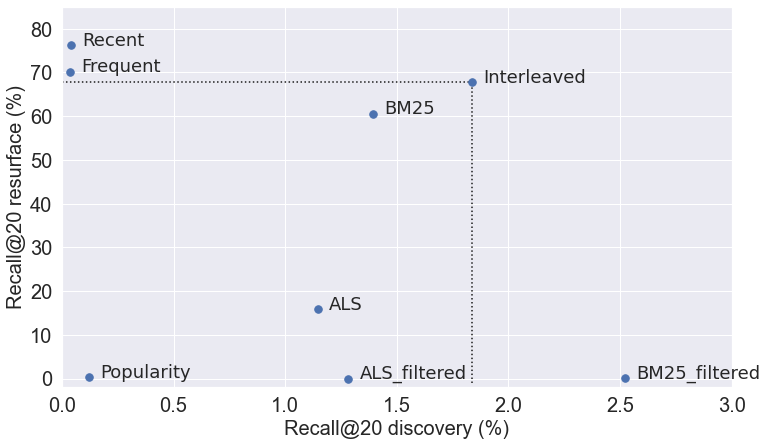

In [ ]:
sns.set_theme(style="darkgrid")
matplotlib.rcParams.update({'font.size': 48, 'figure.figsize':(8,5), 'legend.edgecolor':'k'})


plt.figure(figsize=(12,7))
A = results_df.loc[:,'Recall@20 discovery']
B = results_df.loc[:,'Recall@20 resurface']

x = 2*[results_df.loc[results_df.Recommender == "Interleaved","Recall@20 discovery"].values[0]]
y = [-1, results_df.loc[results_df.Recommender == "Interleaved","Recall@20 resurface"].values[0]]
plt.plot(x,y,":k")
x[0] = 0
y[0] = y[1]
# plt.rcParams.update({'font.size': 48})
plt.rc('xtick', labelsize=3)

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

plt.plot(x,y,":k")

plt.plot(A,B,'.', MarkerSize=15)


for xyz in zip(results_df.Recommender, A, B):                                       # <--
    plt.gca().annotate('%s' % xyz[0], xy=np.array(xyz[1:])+(0.05,0), textcoords='data', fontsize=18) # <--

for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

plt.xlabel("Recall@20 discovery (%)",fontsize=20)
plt.ylabel("Recall@20 resurface (%)",fontsize=20)
plt.xlim([0,3])
plt.ylim([-2,85])
axes = plt.gca()

## Read recs in from files

In [ ]:
recommender_names = ['Popularity', 'Recent', 'Frequent', 'ALS', 'ALS_filtered', 'BM25', 'BM25_filtered', 'Interleaved']

In [ ]:
recs = {rname:wr.load_pickle("../" + rname + "_recs.pickle") for rname in recommender_names}

## Recall curves

In [ ]:
histories_dev = feather.read_feather('../histories_dev_2021-05-28.feather')

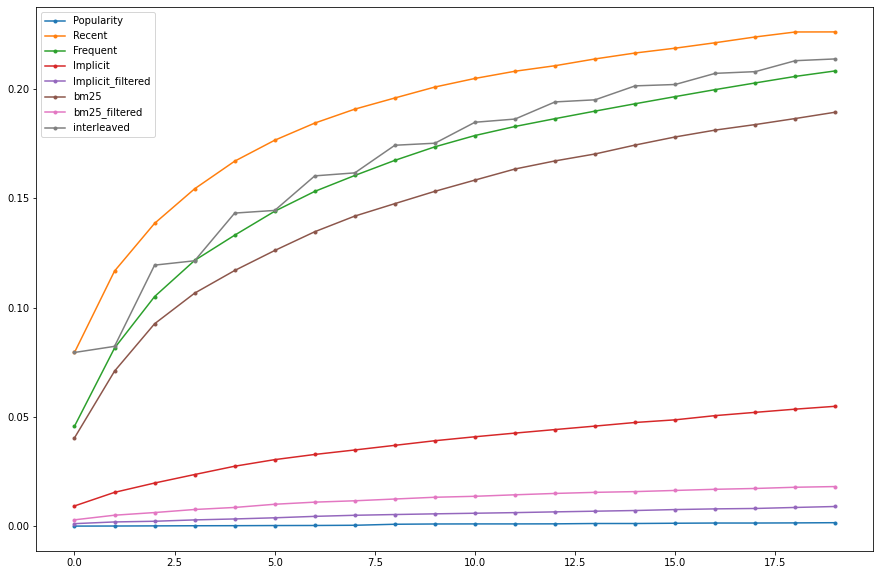

In [ ]:
plt.figure(figsize=(15,10))
for rname in recommender_names:
    recall_curve = wr.recall_curve(histories_dev, recs[rname], 20)
#     print(recall_curve[-1])
    plt.plot(recall_curve,'.-')
plt.legend(recommender_names)

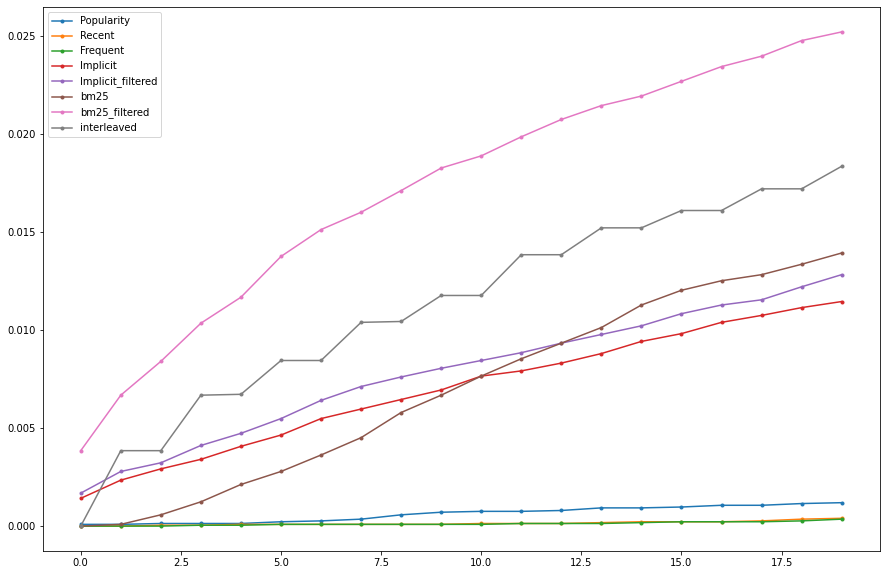

In [ ]:
plt.figure(figsize=(15,10))
for rname in recommender_names:
    recall_curve = wr.recall_curve(histories_dev, recs[rname], 20, discovery_userids)
    plt.plot(recall_curve,'.-')
plt.legend(recommender_names)

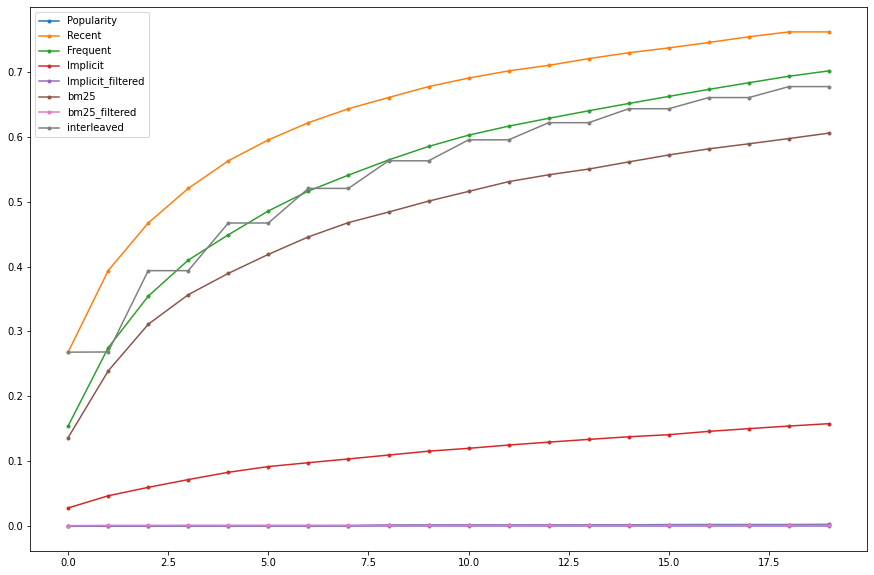

In [ ]:
plt.figure(figsize=(15,10))
for rname in recommender_names:
    recall_curve = wr.recall_curve(histories_dev, recs[rname], 20, resurface_userids)
    plt.plot(recall_curve,'.-')
plt.legend(recommender_names)

### FIG Implicit vs BM25 figure

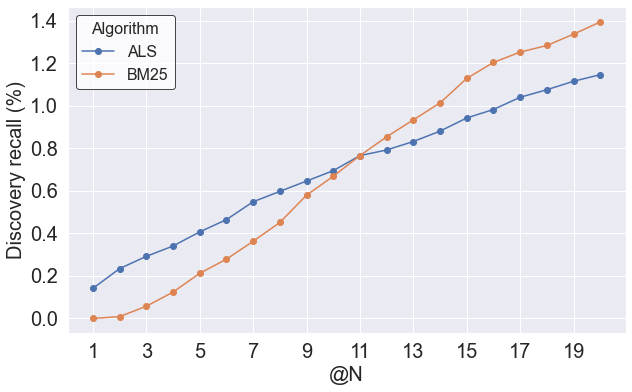

In [ ]:
sns.set_theme(style="darkgrid")
matplotlib.rcParams.update({'font.size': 18, 'figure.figsize':(8,5), 'legend.edgecolor':'k'})
plt.figure(figsize=(10,6))
for rname in ["ALS","BM25"]:
    recall_curve = wr.recall_curve(histories_dev, recs[rname], 20, discovery_userids)
    plt.plot(np.array(recall_curve)*100,'.-',markersize=12)
plt.legend( ["ALS","BM25"],title="Algorithm", fontsize=16, title_fontsize=16, facecolor="w")
plt.xlabel("@N",fontsize=20)
plt.ylabel("Discovery recall (%)",fontsize=20)
_ = plt.xticks(np.arange(0,20,2),np.arange(0,20,2)+1)
# plt.gca().legend(prop=dict(size=20))
for tick in plt.gca().xaxis.get_major_ticks():
    tick.label.set_fontsize(20)
for tick in plt.gca().yaxis.get_major_ticks():
    tick.label.set_fontsize(20)

## User recommendation comparison

In [ ]:
recs_subset = ["Recent","Frequent","Popularity","Implicit","bm25","interleaved"]

In [ ]:
print("Next edit: " + histories_dev.loc[histories_dev.userid == userid].title.values[0])

Next edit: Police van


## FIG Rama table

In [ ]:
def bold_viewed(val, viewed_pages):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    weight = 'bold' if val in  viewed_pages else 'normal'
    return 'font-weight: %s' % weight

def color_target(val, target_page):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    color = 'red' if val ==  target_page else 'black'
    return 'color: %s' % color

def display_user_recs_comparison(user_name, recs, recs_subset, train_set, test_set, N=20):
    userid = n2u[user_name]
    recs_table = pd.DataFrame({rec_name: [p2t[r] for r in recs[rec_name][userid][:N]] for rec_name in recs_subset})
    recs_table = recs_table.reset_index()
    recs_table.loc[:,"index"] = recs_table.loc[:,"index"]+1
    recs_table = recs_table.rename(columns={"index":""})
    viewed_pages = train_set.loc[train_set.userid == userid,["title"]].drop_duplicates(subset=["title"]).values.squeeze()
    target_page = test_set.loc[test_set.userid == userid].title.values[0]
#     print("Next edit: " + target_page)
    s = recs_table.style.applymap(bold_viewed, viewed_pages=viewed_pages).applymap(color_target, target_page=target_page)
    display(s)

In [ ]:
recs_subset = ["Recent","Frequent","Popularity","ALS","ALS_filtered","BM25","BM25_filtered"]

display_user_recs_comparison('Rama', recs, recs_subset, histories_train, histories_dev, N=10)

,,Recent,Frequent,Popularity,ALS,ALS_filtered,BM25,BM25_filtered
0,1,Andrew Lee (entrepreneur),Joseph de Flotte,"Prince Philip, Duke of Edinburgh",Joseph de Flotte,HMS Triton (1796),Battle of Fort Royal,Battle of the Mona Passage
1,2,Freenode,French fluyt Gros Ventre (1767),2020–2021 Belarusian protests,French fluyt Gros Ventre (1767),Battle of the Mona Passage,Nicolas Henri de Grimouard,Great Siege of Gibraltar
2,3,Long Range Acoustic Device,First voyage of Kerguelen,Chadwick Boseman,First voyage of Kerguelen,HMS Sylph,French frigate Boudeuse (1766),Anglo-French War (1778–1783)
3,4,French ship Adelaide (1699),Battle of Fort Royal,2024 United States presidential election,Battle of Fort Royal,HMS Sylph (1795),Joseph de Flotte,Invasion of Martinique (1809)
4,5,French frigate Muiron,Louis Charles du Chaffault de Besné,COVID-19 pandemic in the United States,Louis Charles du Chaffault de Besné,Great Siege of Gibraltar,French fluyt Gros Ventre (1767),Action of 12 December 1779
5,6,Future French aircraft carrier,Robert Surcouf,Black Lives Matter,French frigate Flore (1769),Battle of Pulo Aura,French frigate Flore (1769),Action of 17 June 1778
6,7,French Naval Aviation,Future French aircraft carrier,George Floyd,Battle of St. Lucia,Battle of Nieuwpoort,First voyage of Kerguelen,Action of 17 August 1779
7,8,NHIndustries NH90,Jacques de Grenier,Derek Chauvin,Jacques de Grenier,HMS Alceste (1806),Battle of St. Lucia,American Revolutionary War
8,9,French frigate Auvergne,French frigate Flore (1769),2021 Israel–Palestine crisis,Battle of Grenada,French frigate Sibylle (1792),Louis Charles du Chaffault de Besné,France in the American Revolutionary War
9,10,EMPAR,Battle of St. Lucia,Zack Snyder's Justice League,Robert Surcouf,HMS Amethyst (1799),USS Hancock (1776),British Army during the American Revolutionary War


## Other individuals tables

In [ ]:
display_user_recs_comparison('Meow', recs, recs_subset, histories_train, histories_dev, N=10)

,index,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,1,MediaWiki,2020 Pacific typhoon season,"Prince Philip, Duke of Edinburgh",Tropical cyclones in 2021,Tropical cyclones in 2020,2020–21 South Pacific cyclone season,Tropical cyclones in 2020
1,2,Zombo.com,2020–21 Australian region cyclone season,2020–2021 Belarusian protests,2020–21 Australian region cyclone season,Cyclone Yasa,2020–21 Australian region cyclone season,Cyclone Ana
2,3,Comparison of wiki software,2020–21 South-West Indian Ocean cyclone season,Chadwick Boseman,2020–21 South-West Indian Ocean cyclone season,Cyclone Eloise,2020–21 South-West Indian Ocean cyclone season,2021 Pacific hurricane season
3,4,2021 North Indian Ocean cyclone season,2020–21 South Pacific cyclone season,2024 United States presidential election,2020–21 South Pacific cyclone season,Cyclone Ana,Typhoon Haishen (2020),Cyclone Kimi
4,5,PukiWiki,2021 Pacific typhoon season,COVID-19 pandemic in the United States,2021 North Indian Ocean cyclone season,2021 Pacific hurricane season,2020 Pacific typhoon season,Cyclone Yasa
5,6,2021 Pacific typhoon season,2020 North Indian Ocean cyclone season,Black Lives Matter,2020 Pacific typhoon season,2020–21 North American winter,2020 North Indian Ocean cyclone season,Typhoon Molave
6,7,Linkou Plateau,South Atlantic tropical cyclone,George Floyd,2020 North Indian Ocean cyclone season,2020 Atlantic hurricane season,2021 Pacific typhoon season,Cyclone Niran
7,8,List of the most intense tropical cyclones,MacOS Big Sur,Derek Chauvin,Typhoon Surigae,Hurricane Iota,South Atlantic tropical cyclone,2019–20 Australian region cyclone season
8,9,National Freeway 3,Typhoon Haishen (2020),2021 Israel–Palestine crisis,2021 Pacific typhoon season,Hurricane Eta,Typhoon Surigae,2018 Pacific typhoon season
9,10,Tamsui River,2021 North Indian Ocean cyclone season,Zack Snyder's Justice League,Tropical cyclones in 2020,2020 Pacific hurricane season,Typhoon Vongfong (2020),2021 Atlantic hurricane season


In [ ]:
display_user_recs_comparison('KingArti', recs, recs_subset, histories_train, histories_dev, N=10)

,,Recent,Frequent,Popularity,ALS,ALS_filtered,BM25,BM25_filtered
0,1,Marvel Cinematic Universe: Phase Four,Ms. Marvel (TV series),"Prince Philip, Duke of Edinburgh",Black Adam (film),Peacemaker (TV series),Ms. Marvel (TV series),The Marvels (film)
1,2,List of Marvel Cinematic Universe television series,Marvel Cinematic Universe: Phase Four,2020–2021 Belarusian protests,The Flash (film),Morbius (film),Thor: Love and Thunder,List of Marvel Cinematic Universe television series actors (Marvel Television)
2,3,Laith Nakli,WandaVision,Chadwick Boseman,Peacemaker (TV series),Venom: Let There Be Carnage,Doctor Strange in the Multiverse of Madness,Ant-Man and the Wasp
3,4,Iman Vellani,Iman Vellani,2024 United States presidential election,Thor: Love and Thunder,List of Marvel Cinematic Universe films,Eternals (film),Spider-Man: Far From Home
4,5,Ms. Marvel (TV series),List of Marvel Cinematic Universe television series,COVID-19 pandemic in the United States,The Suicide Squad (film),Sony Pictures Universe of Marvel Characters,She-Hulk (TV series),Marvel Studios: Assembled
5,6,Ant-Man and the Wasp: Quantumania,The Falcon and the Winter Soldier,Black Lives Matter,Doctor Strange in the Multiverse of Madness,Nick Fury (Marvel Cinematic Universe),Shang-Chi and the Legend of the Ten Rings,Sony Pictures Universe of Marvel Characters
6,7,Thor: Love and Thunder,DC Extended Universe,George Floyd,Shang-Chi and the Legend of the Ten Rings,Captain Marvel (film),Hawkeye (2021 TV series),List of Marvel Cinematic Universe film actors
7,8,Moon Knight (TV series),Spider-Man: No Way Home,Derek Chauvin,Spider-Man: No Way Home,The Marvels (film),Spider-Man: No Way Home,Marvel's Netflix television series
8,9,Eternals (film),Kevin Feige,2021 Israel–Palestine crisis,The Falcon and the Winter Soldier,Spider-Man: Far From Home,Loki (TV series),Marvel Cinematic Universe
9,10,Obi-Wan Kenobi (TV series),Thor: Love and Thunder,Zack Snyder's Justice League,Morbius (film),Shazam! Fury of the Gods,Ant-Man and the Wasp: Quantumania,List of Marvel Cinematic Universe films


In [ ]:
display_user_recs_comparison('Tulietto', recs, recs_subset, histories_train, histories_dev, N=10)

Next edit: Demographics of Poland


,Recent,Frequent,Popularity,Implicit,bm25,interleaved
0,Demography of Wales,Demography of Wales,"Prince Philip, Duke of Edinburgh",Demographics of Bosnia and Herzegovina,Demographics of Slovakia,Demography of Wales
1,Demography of England,Demography of England,2020–2021 Belarusian protests,Demographics of Croatia,Demographics of Luxembourg,Demographics of Bulgaria
2,Demographics of Portugal,Demography of Northern Ireland,Chadwick Boseman,Demographics of Slovenia,Demographics of Argentina,Demography of England
3,Demography of Scotland,Demographics of Switzerland,2024 United States presidential election,Demographics of Montenegro,Demographics of Iran,Demographics of South Korea
4,Demographics of New Zealand,Demographics of Portugal,COVID-19 pandemic in the United States,Demographics of Portugal,Demographics of Sweden,Demographics of Portugal
5,Demographics of the United States,Demographics of Colombia,Black Lives Matter,Demography of Wales,Demographics of Iceland,Demographics of Montenegro
6,Demographics of Andorra,Demography of Scotland,George Floyd,Demographics of Serbia,Demographics of the Czech Republic,Demography of Scotland
7,Demographics of the Republic of Ireland,Demographics of France,Derek Chauvin,Demographics of North Macedonia,Demographics of Romania,Demographics of Slovenia
8,Demographics of Cuba,Demographics of Romania,2021 Israel–Palestine crisis,Demographics of Kosovo,Demographics of France,Demographics of New Zealand
9,Demography of Northern Ireland,Demographics of Sweden,Zack Snyder's Justice League,Demographics of Romania,Demographics of Germany,Demographics of Bosnia and Herzegovina


In [ ]:
display_user_recs_comparison('Thornstrom', recs, recs_subset, histories_train, histories_dev, N=10)

Next edit: List of Netflix original films (2021–)


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,Ghost Lab (film),List of Netflix original programming,"Prince Philip, Duke of Edinburgh",Lists of Netflix original films,List of Amazon Prime Video original programming,Lists of Netflix original films,List of Amazon Prime Video original programming
1,List of Netflix original films (2021–),Lists of Netflix original films,2020–2021 Belarusian protests,List of Netflix original programming,List of Hulu original programming,List of Netflix original films (2021–),List of Amazon Studios films
2,Baggio: The Divine Ponytail,List of Netflix original films (2021–),Chadwick Boseman,List of Netflix original films (2021–),List of Peacock original programming,List of Netflix original programming,List of Hulu original programming
3,I Am All Girls,List of Netflix exclusive international distribution programming,2024 United States presidential election,List of Netflix exclusive international distribution programming,List of Lionsgate films,List of Netflix original stand-up comedy specials,List of Peacock original programming
4,Ferry (film),The Heartbreak Club,COVID-19 pandemic in the United States,List of ended Netflix original programming,List of HBO Max original programming,List of Netflix exclusive international distribution programming,List of Showtime original programming
5,Disney+,List of Netflix original films (2020),Black Lives Matter,List of Amazon Prime Video original programming,List of HBO original programming,List of ended Netflix original programming,List of HBO original programming
6,Millarworld,La Révolution,George Floyd,List of Hulu original programming,List of Showtime original programming,List of Amazon Prime Video original programming,List of programs broadcast by AMC
7,List of best-selling Nintendo Switch video games,Freaks: You're One of Us,Derek Chauvin,List of Peacock original programming,List of programs broadcast by AMC,List of Netflix original films (2020),List of Lionsgate films
8,List of Netflix original programming,Geez & Ann,2021 Israel–Palestine crisis,List of Netflix original films (2020),List of Saban Films films,List of Netflix original films (2015–2017),List of Disney+ original films
9,List of ended Netflix original programming,"Love, Guaranteed",Zack Snyder's Justice League,List of Netflix original stand-up comedy specials,List of Paramount+ original programming,List of Amazon Studios films,List of Disney+ original programming


## FIG Interleaved

In [ ]:
display_user_recs_comparison('Rama', recs,['Interleaved'], histories_train, histories_dev, N=10)

,,Interleaved
0,1,Andrew Lee (entrepreneur)
1,2,Battle of the Mona Passage
2,3,Freenode
3,4,Great Siege of Gibraltar
4,5,Long Range Acoustic Device
5,6,Anglo-French War (1778–1783)
6,7,French ship Adelaide (1699)
7,8,Invasion of Martinique (1809)
8,9,French frigate Muiron
9,10,Action of 12 December 1779


In [ ]:
display_user_recs_comparison('KingArti', recs,['Interleaved'], histories_train, histories_dev, N=10)

,,Interleaved
0,1,Marvel Cinematic Universe: Phase Four
1,2,The Marvels (film)
2,3,List of Marvel Cinematic Universe television series
3,4,List of Marvel Cinematic Universe television series actors (Marvel Television)
4,5,Laith Nakli
5,6,Ant-Man and the Wasp
6,7,Iman Vellani
7,8,Spider-Man: Far From Home
8,9,Ms. Marvel (TV series)
9,10,Marvel Studios: Assembled


In [ ]:
N = 20
display(pd.DataFrame({rec_name: [p2t[r] for r in recs[rec_name][n2u['HenryXVII']]][:N] for rec_name in recs_subset}))

,Recent,Frequent,Popularity,Implicit,bm25
0,Meanings of minor planet names: 17001–18000,"Constance, Queen of Sicily","Prince Philip, Duke of Edinburgh",Philip II of France,"Beatrice I, Countess of Burgundy"
1,"Margaret of Burgundy, Queen of France",William II of Sicily,2020–2021 Belarusian protests,"Beatrice I, Countess of Burgundy",William II of Sicily
2,Antipope Paschal III,"Beatrice I, Countess of Burgundy",Chadwick Boseman,Joan I of Navarre,Margaret of Navarre
3,Wu Mengchao,Margaret of Navarre,2024 United States presidential election,William II of Sicily,"Eleanor, Fair Maid of Brittany"
4,List of French royal consorts,"Tancred, King of Sicily",COVID-19 pandemic in the United States,Philip III of France,"Constance, Queen of Sicily"
5,Yevdokiya Lopukhina,Timeline of the Middle Ages,Black Lives Matter,Joanna I of Naples,"Tancred, King of Sicily"
6,Washington family,"Frederick I, Holy Roman Emperor",George Floyd,Biette de Cassinel,"Roger III, Duke of Apulia"
7,"Constance, Duchess of Brittany","Eleanor, Fair Maid of Brittany",Derek Chauvin,Philip of Swabia,The Thunder (TV series)
8,James Francis Edward Stuart,Blanche of Burgundy,2021 Israel–Palestine crisis,Louis X of France,Bi Shiduo
9,Louis VIII of France,"Margaret of Burgundy, Queen of France",Zack Snyder's Justice League,Louis XI,Treaty of Venice


In [ ]:
persons_of_interest = [
    "DoctorWho42",
    "AxelSjögren",
    "Mighty platypus",
    "Tulietto",
    "LipaCityPH",
    "Hesperian Nguyen",
    "Thornstrom",
    "Meow",
    "HyprMarc",
    "Jampilot",
    "Rama"
]
N=10

In [ ]:
irec_500 = recommenders.ImplicitCollaborativeRecommender(model, implicit_matrix)
irecs_poi = irec_500.recommend_all([n2u[user_name] for user_name in persons_of_interest], N, u2i=u2i, n2i=n2i, i2p=i2p)

  0%|          | 0/12 [00:00<?, ?it/s]

## Find interesting users

In [ ]:
edited_pages = clean_histories.drop_duplicates(subset=['title','user']).groupby('user').userid.count()

edited_pages = edited_pages[edited_pages > 50]
edited_pages = edited_pages[edited_pages < 300]

In [ ]:
clean_histories.columns

Index(['userid', 'user', 'pageid', 'title', 'first_timestamp',
       'last_timestamp', 'sum_sizediff', 'consecutive_edits'],
      dtype='object')

In [ ]:
display_user_recs_comparison("Rama", recs, recs_subset, histories_train, histories_dev, N=20)

Next edit: Freenode


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,Andrew Lee (entrepreneur),Joseph de Flotte,"Prince Philip, Duke of Edinburgh",Joseph de Flotte,HMS Triton (1796),Battle of Fort Royal,Battle of the Mona Passage
1,Freenode,French fluyt Gros Ventre (1767),2020–2021 Belarusian protests,French fluyt Gros Ventre (1767),Battle of the Mona Passage,Nicolas Henri de Grimouard,Great Siege of Gibraltar
2,Long Range Acoustic Device,First voyage of Kerguelen,Chadwick Boseman,First voyage of Kerguelen,HMS Sylph,French frigate Boudeuse (1766),Anglo-French War (1778–1783)
3,French ship Adelaide (1699),Battle of Fort Royal,2024 United States presidential election,Battle of Fort Royal,HMS Sylph (1795),Joseph de Flotte,Invasion of Martinique (1809)
4,French frigate Muiron,Louis Charles du Chaffault de Besné,COVID-19 pandemic in the United States,Louis Charles du Chaffault de Besné,Great Siege of Gibraltar,French fluyt Gros Ventre (1767),Action of 12 December 1779
5,Future French aircraft carrier,Robert Surcouf,Black Lives Matter,French frigate Flore (1769),Battle of Pulo Aura,French frigate Flore (1769),Action of 17 June 1778
6,French Naval Aviation,Future French aircraft carrier,George Floyd,Battle of St. Lucia,Battle of Nieuwpoort,First voyage of Kerguelen,Action of 17 August 1779
7,NHIndustries NH90,Jacques de Grenier,Derek Chauvin,Jacques de Grenier,HMS Alceste (1806),Battle of St. Lucia,American Revolutionary War
8,French frigate Auvergne,French frigate Flore (1769),2021 Israel–Palestine crisis,Battle of Grenada,French frigate Sibylle (1792),Louis Charles du Chaffault de Besné,France in the American Revolutionary War
9,EMPAR,Battle of St. Lucia,Zack Snyder's Justice League,Robert Surcouf,HMS Amethyst (1799),USS Hancock (1776),British Army during the American Revolutionary War


In [ ]:
index = list(range(len(edited_pages)))
np.random.shuffle(index)

for i in index[:10]:
    user_name = edited_pages.index[i]
    print(user_name)
    display_user_recs_comparison(user_name, recs, recs_subset, histories_train, histories_dev, N=20)
    print("\n\n\n")

Publichall
Next edit: Lyon Building


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,First National Bank of Eddy,William E. Boone,"Prince Philip, Duke of Edinburgh",Angeline Lake,Angeline Lake,Interurban Building (Seattle),Interstate 205 (Oregon–Washington)
1,Naveed (song),Interurban Building (Seattle),2020–2021 Belarusian protests,William E. Boone,Robert Shields (diarist),Colman Building,Dell Loy Hansen
2,Right Behind You (Mafia),Elmer H. Fisher,Chadwick Boseman,Robert Shields (diarist),List of waterfalls of Washington (state),Union Trust Building (Seattle),Shoreline North/185th station
3,William Rankin Ballard,Colman Building,2024 United States presidential election,List of waterfalls of Washington (state),Cooper Lake (Washington),Agen Warehouse,Interstate 405 (Oregon)
4,Interurban Building (Seattle),Mottman Building,COVID-19 pandemic in the United States,Cooper Lake (Washington),Lake Ethel,Grand Pacific Hotel (Seattle),University Street station
5,Naveed (album),Rector Hotel,Black Lives Matter,Smith Tower,Lake Ida (Washington),Rector Hotel,Stadium station (Sound Transit)
6,Happiness... Is Not a Fish That You Can Catch,"Masonic Lodge Building (Kirkland, Washington)",George Floyd,Union Trust Building (Seattle),Lake Augusta (Washington),Lyon Building,MLS Cup 2000
7,Spiritual Machines,"Umatilla, Oregon",Derek Chauvin,Interurban Building (Seattle),"Kirkland, Washington",Holyoke Building,"Granite Falls, Washington"
8,Gravity (Our Lady Peace album),Agen Warehouse,2021 Israel–Palestine crisis,Lake Ethel,U District station,Smith Tower,MLS Cup 1999
9,Clumsy (Our Lady Peace album),Union Trust Building (Seattle),Zack Snyder's Justice League,Lake Ida (Washington),Interstate 5 in Washington,Colonial Hotel (Seattle),List of tallest buildings in Seattle






HornetMike
Next edit: Richard Johnson (soccer)


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,Michał Karbownik,England national under-21 football team,"Prince Philip, Duke of Edinburgh",Jamal Lowe,Jamal Lowe,England national under-21 football team,England national under-17 football team
1,Troy Deeney,England national under-20 football team,2020–2021 Belarusian protests,2020–21 Brighton & Hove Albion F.C. season,2020–21 Brighton & Hove Albion F.C. season,England national under-20 football team,List of Plymouth Argyle F.C. records and statistics
2,Hulme,Watford F.C.,Chadwick Boseman,2020–21 Blackburn Rovers F.C. season,2020–21 Blackburn Rovers F.C. season,England national under-19 football team,Chris Old
3,2021 Manchester City Council election,England national under-19 football team,2024 United States presidential election,2020–21 Aston Villa F.C. season,2020–21 Aston Villa F.C. season,England national under-18 football team,Mikael Ndjoli
4,Guardian Football Weekly,FA Youth Cup Finals,COVID-19 pandemic in the United States,Marc Guéhi,Marc Guéhi,England under-19 cricket team,2019–20 Manchester City F.C. season
5,List of English association football families,Troy Deeney,Black Lives Matter,Jay Fulton,Jay Fulton,Thomas Agyepong,Cole Palmer
6,Watford F.C.,England national under-18 football team,George Floyd,2020–21 Sheffield United F.C. season,2020–21 Sheffield United F.C. season,FA Youth Cup Finals,List of West Bromwich Albion F.C. seasons
7,2012 Under-19 Cricket World Cup squads,England under-19 cricket team,Derek Chauvin,Freddie Woodman,Freddie Woodman,Allan Smart,Manchester City F.C.
8,South Africa national cricket team,2021 Manchester City Council election,2021 Israel–Palestine crisis,2020–21 Milton Keynes Dons F.C. season,2020–21 Milton Keynes Dons F.C. season,Joao Pedro (Brazilian footballer),Aidy Boothroyd
9,The Guardian,South Africa national cricket team,Zack Snyder's Justice League,Sheffield United F.C.,Sheffield United F.C.,McPherson report,2017–18 Manchester City F.C. season






Johannes Maximilian
Next edit: Manifold injection


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,Gnome Delta,Diesel engine,"Prince Philip, Duke of Edinburgh",Hyundai Lambda engine,Hyundai Lambda engine,Mercedes-Benz OM636 engine,BMW M4
1,Armstrong Siddeley Python,BMW,2020–2021 Belarusian protests,Dodge Durango,Dodge Durango,Mercedes-Benz L 337,BMW 5 Series (G30)
2,Duramax I6 engine,Rudolf Diesel,Chadwick Boseman,Lexus LS,Lexus LS,Unimog 406,BMW 8 Series (G15)
3,MWM AKD 112 Z,Fuel injection,2024 United States presidential election,Ford Explorer,Ford Explorer,Diesel engine,BMW 6 Series
4,Unimog 401,Volkswagen Kommandeurswagen,COVID-19 pandemic in the United States,List of Hyundai transmissions,List of Hyundai transmissions,Trabant 601,BMW 3 Series (E36)
5,Hongqi S9,Diesel fuel,Black Lives Matter,Chevrolet Impala,Chevrolet Impala,Fuel injection,BMW 7 Series
6,Rudolf Diesel,Unimog,George Floyd,List of fastest production cars by acceleration,List of fastest production cars by acceleration,Mercedes-Benz short-bonnet trucks,BMW 6 Series (F12)
7,Oscar Lintz,Mercedes-Benz W124,Derek Chauvin,BMW,Production car speed record,Theory and Construction of a Rational Heat Motor,BMW 4 Series (G22)
8,BMW M8,Ikarus 280,2021 Israel–Palestine crisis,Production car speed record,Kia Opirus,Mercedes-Benz OM352 engine,BMW M54
9,Unimog 425,Pandur II,Zack Snyder's Justice League,Kia Opirus,Hyundai Theta engine,Unimog 435,BMW 7 Series (E38)






Ian.thomson
Next edit: Teal Swan


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,Indian pariah dog,Classification of demons,"Prince Philip, Duke of Edinburgh",Abomination of desolation,Abomination of desolation,The infernal names,Biblical literalism
1,Solomon,List of Sufi saints,2020–2021 Belarusian protests,Yahwism,Yahwism,George Winslow Plummer,Devil in Christianity
2,Mark Halperin,List of theological demons,Chadwick Boseman,Empty tomb,Empty tomb,"Miana, Turkmenistan",Genealogy of Jesus
3,The Lesser Key of Solomon,Star Wars: The Rise of Skywalker,2024 United States presidential election,Gospel of James,Gospel of James,Asif ibn Barkhiya,Devil
4,Book of Revelation,Adam Weishaupt,COVID-19 pandemic in the United States,Yahweh,Yahweh,List of phonograph manufacturers,Paul the Apostle
5,Indian astronomy,Julius Evola,Black Lives Matter,The Exodus,The Exodus,The King Stays King,Christian eschatology
6,Trinity,Valac,George Floyd,Book of Daniel,Book of Daniel,Women in Africa,Hadith
7,Zoroaster,Paimon,Derek Chauvin,Census of Quirinius,Census of Quirinius,Urban riots,Holy Spirit
8,Grits,Salem bin Laden,2021 Israel–Palestine crisis,Gospel of Matthew,Gospel of Matthew,Campaign (magazine),Satan
9,The King Stays King,Hermetica,Zack Snyder's Justice League,Gospel,Gospel,Daud Bandagi Kirmani,Deuterocanonical books






DarkStriker22
Next edit: Philippines national football team


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,Gerrit Holtmann,Loyola F.C.,"Prince Philip, Duke of Edinburgh",Gilbert Gapay,Gilbert Gapay,Kaya F.C.–Iloilo,2019 Philippines Football League
1,Michael Kempter,Maharlika Manila F.C.,2020–2021 Belarusian protests,Protests against Rodrigo Duterte,Protests against Rodrigo Duterte,Loyola F.C.,2017 Philippines Football League
2,Jefferson Tabinas,Novem Baumann,Chadwick Boseman,COVID-19 pandemic in Metro Manila,COVID-19 pandemic in Metro Manila,Maharlika Manila F.C.,2018 Philippines Football League
3,Jesper Nyholm,Michael Kempter,2024 United States presidential election,MRT Line 3 (Metro Manila),MRT Line 3 (Metro Manila),Azkals Development Team,Jerry Barbaso
4,Kevin Ray Mendoza,Ben&Ben,COVID-19 pandemic in the United States,ABS-CBN franchise renewal controversy,ABS-CBN franchise renewal controversy,Patrick Asare,2021 Philippines Football League
5,Niko de Vera,United City F.C.,Black Lives Matter,PMA Sinagtala Class of 1986,PMA Sinagtala Class of 1986,Jason Withe,Serge Kaole
6,Amani Aguinaldo,2020 Philippines Football League,George Floyd,Cirilito Sobejana,Cirilito Sobejana,Stallion Laguna F.C.,James Younghusband
7,2021–22 Thai League 1,Ben&Ben discography,Derek Chauvin,Alma Uy-Lampasa,Alma Uy-Lampasa,Novem Baumann,Anton del Rosario
8,Matthew Baldisimo,Clara Benin,2021 Israel–Palestine crisis,COVID-19 pandemic in Central Visayas,COVID-19 pandemic in Central Visayas,Michael Kempter,Philippines Football League
9,Paulo Junichi Tanaka,Fragments (Clara Benin EP),Zack Snyder's Justice League,Philippine government response to the COVID-19 pandemic,Philippine government response to the COVID-19 pandemic,Clara Benin,Misagh Bahadoran






SilentGanda
Next edit: 2022 Formula One World Championship


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,2020 Styrian Grand Prix,WWE,"Prince Philip, Duke of Edinburgh",Cody Rhodes,Cody Rhodes,SummerSlam (2020),NXT TakeOver: Vengeance Day
1,Formula One sponsorship liveries,List of current champions in WWE,2020–2021 Belarusian protests,Hard To Kill (2021),Hard To Kill (2021),NXT TakeOver XXX,NXT TakeOver: WarGames (2020)
2,The Amazing Race 21,ASEAN Summit,Chadwick Boseman,A.J. Styles,A.J. Styles,Clash of Champions (2020),WWE Intercontinental Championship
3,2021 Myanmar protests,WWE Backlash,2024 United States presidential election,SmackDown (WWE brand),SmackDown (WWE brand),NXT TakeOver: Vengeance Day,NXT TakeOver: Stand & Deliver
4,2021 Myanmar coup d'état,WWE Hell in a Cell,COVID-19 pandemic in the United States,Rebellion (2021),Rebellion (2021),Royal Rumble (2021),Survivor Series (2020)
5,East Asia Summit,Member states of the Association of Southeast Asian Nations,Black Lives Matter,Jon Moxley,Jon Moxley,NXT TakeOver: WarGames (2020),"TLC: Tables, Ladders & Chairs (2020)"
6,Member states of the Association of Southeast Asian Nations,WWE Clash of Champions,George Floyd,All Elite Wrestling,All Elite Wrestling,WWE Intercontinental Championship,NXT TakeOver: In Your House (2020)
7,ASEAN Summit,List of WWE pay-per-view and WWE Network events,Derek Chauvin,WWE,Impact Knockouts Tag Team Championship,NXT TakeOver: Stand & Deliver,Payback (2020)
8,Big Brother Canada (season 9),WWE Extreme Rules,2021 Israel–Palestine crisis,Impact Knockouts Tag Team Championship,Roman Reigns,Hell in a Cell (2020),NXT TakeOver
9,Elimination Chamber,East Asia Summit,Zack Snyder's Justice League,Roman Reigns,FTR (professional wrestling),WWE Clash of Champions,NXT TakeOver 31






Raleigh80Z90Faema69
Next edit: Vuelta a España records and statistics


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,Luz Ardiden,2020 Tour de France,"Prince Philip, Duke of Edinburgh",Wout van Aert,Wout van Aert,Freddy Maertens,Giacomo Nizzolo
1,Dan Martin (cyclist),Primož Roglič,2020–2021 Belarusian protests,List of wins by Kwantum–Decosol–Yoko and its successors,List of wins by Kwantum–Decosol–Yoko and its successors,Fred Rodriguez,Ben Hermans
2,Brandon McNulty,Luz Ardiden,Chadwick Boseman,List of wins by Bahrain–Merida and its successors,List of wins by Bahrain–Merida and its successors,2008 Tour de France,Jasper Philipsen
3,Daniel Martínez (cyclist),Joop Zoetemelk,2024 United States presidential election,List of wins by Cycling Academy Team and its successors,List of wins by Cycling Academy Team and its successors,Luz Ardiden,Alessandro De Marchi (cyclist)
4,Gino Bartali,Tour de France,COVID-19 pandemic in the United States,List of wins by Team NetApp and its successors,List of wins by Team NetApp and its successors,Alfons De Wolf,Nacer Bouhanni
5,Artūras Kasputis,2008 Tour de France,Black Lives Matter,List of wins by Colnago–Lampre and its successors,List of wins by Colnago–Lampre and its successors,Henry Anglade,Luca Mozzato
6,Egan Bernal,Tadej Pogačar,George Floyd,List of wins by Bonjour and its successors,List of wins by Bonjour and its successors,1971 Tour de France,Stefan Küng
7,Tejay van Garderen,Greg LeMond,Derek Chauvin,List of wins by BMC Racing Team and its successors,List of wins by BMC Racing Team and its successors,Davis Phinney,Sonny Colbrelli
8,Eldon Bargewell,Lance Armstrong,2021 Israel–Palestine crisis,List of wins by Quick-Step–Davitamon and its successors,List of wins by Quick-Step–Davitamon and its successors,Georg Totschnig,Caleb Ewan
9,John Gilstrap,Guillaume Martin,Zack Snyder's Justice League,List of wins by BKCP–Powerplus and its successors,List of wins by BKCP–Powerplus and its successors,Andy Schleck,Nairo Quintana






FN17
Next edit: 2021 NJ/NY Gotham FC season


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,2021 NJ/NY Gotham FC season,2020 Sky Blue FC season,"Prince Philip, Duke of Edinburgh",NJ/NY Gotham FC,Orlando Pride,NJ/NY Gotham FC,2020 Pennsylvania State Treasurer election
1,NJ/NY Gotham FC,NJ/NY Gotham FC,2020–2021 Belarusian protests,2020 Sky Blue FC season,2020 Orlando City SC season,2020 Pennsylvania Auditor General election,Washington Spirit
2,2020–21 EFL Championship,2020 Pennsylvania Auditor General election,Chadwick Boseman,2020 Pennsylvania Auditor General election,Alex Morgan,Nahomi Kawasumi,2020 United States Senate election in Wyoming
3,2022 Pennsylvania gubernatorial election,2021 NJ/NY Gotham FC season,2024 United States presidential election,2021 NJ/NY Gotham FC season,2021 Orlando City SC season,2021 NJ/NY Gotham FC season,2020 United States Senate election in Alaska
4,Kostas Tsimikas,2022 Pennsylvania gubernatorial election,COVID-19 pandemic in the United States,Orlando Pride,2021 NWSL Draft,2022 Pennsylvania gubernatorial election,Julia Ashley
5,2020–21 Liverpool F.C. season,2020 NWSL Challenge Cup,Black Lives Matter,2020 Orlando City SC season,2021 Orlando Pride season,Timothy DeFoor,2020 United States Senate election in Delaware
6,2020–21 Rangers F.C. season,2022 United States Senate election in Pennsylvania,George Floyd,2020 NWSL Challenge Cup,Daryl Dike,2020 Sky Blue FC season,2020 United States Senate election in Kentucky
7,Chicago Red Stars,"Towamencin Township, Montgomery County, Pennsylvania",Derek Chauvin,Alex Morgan,Andrés Perea,Government of Pennsylvania,Olympique Lyonnais Féminin
8,Portland Thorns FC,2020–21 Liverpool F.C. season,2021 Israel–Palestine crisis,2021 Orlando City SC season,List of Orlando City SC records and statistics,Elizabeth Eddy,Houston Dash
9,2021 NWSL Challenge Cup,Timothy DeFoor,Zack Snyder's Justice League,2021 NWSL Draft,Exploria Stadium,"Towamencin Township, Montgomery County, Pennsylvania",2020 Portland Thorns FC season






CrimsonComputer
Next edit: List of Melodi Grand Prix winners


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,Krista Siegfrids,Scratch (programming language),"Prince Philip, Duke of Edinburgh",Mobile operating system,Mobile operating system,Groovy Gorilla,Mac transition to Apple silicon
1,List of teams and cyclists in the 2021 Tour de France,Microsoft Teams,2020–2021 Belarusian protests,Adobe Flash,Adobe Flash,Qaleh Tarfi,Kanchō
2,List of MPs elected in the 2019 United Kingdom general election,Natural dye,Chadwick Boseman,Web browser,Web browser,Solanum violaceum,MacOS Big Sur
3,P. Sathasivam,List of most-subscribed YouTube channels,2024 United States presidential election,Motherboard,Motherboard,Hirsute Hippo,ScratchJr
4,-yllion,Raspberry Pi OS,COVID-19 pandemic in the United States,Adobe Flash Player,Adobe Flash Player,Morphic (software),Rosetta (software)
5,Age verification system,P. Sathasivam,Black Lives Matter,Transport Layer Security,Transport Layer Security,1925 Tour de France,Mac Mini
6,Ubuntu version history,Debian version history,George Floyd,DVD,DVD,Gerbil (disambiguation),Apple A12Z
7,"Thourio, Evros",Krista Siegfrids,Derek Chauvin,Email,Email,Krista Siegfrids,Gerald Betts
8,Scratch (programming language),Qaleh Tarfi,2021 Israel–Palestine crisis,Google Drive,Google Drive,Ogwashi Ukwu,Apple M1
9,Debian version history,David Coote (cricketer),Zack Snyder's Justice League,Simple Mail Transfer Protocol,Simple Mail Transfer Protocol,Cadbury Dairy Milk Caramel,NORAD Tracks Santa






Felipevmvillalobos
Next edit: Miss Universe 2020


,Recent,Frequent,Popularity,Implicit,Implicit_filtered,bm25,bm25_filtered
0,Miss Universe 2020,Miss Universe 2018,"Prince Philip, Duke of Edinburgh",Miss Universe 2019,Miss Earth 2020,Miss Universe 2018,List of Miss Universe titleholders
1,Miss Universe 2021,Miss Universe 2019,2020–2021 Belarusian protests,Miss Earth 2020,List of beauty pageants,Miss Universe 2019,Miss Venezuela
2,Miss Universe 1998,Miss Universe 2017,Chadwick Boseman,Miss Universe 2018,Puteri Indonesia,Miss Universe 2014,Miss Universe
3,Miss Universe 2000,Miss Universe 2016,2024 United States presidential election,List of beauty pageants,Miss France 2021,Miss Universe 2016,Zozibini Tunzi
4,Miss Universe 2001,Miss Universe 2014,COVID-19 pandemic in the United States,Puteri Indonesia,Philippines at major beauty pageants,Miss Universe 2011,Miss Earth 2020
5,Miss Universe 2003,Miss Universe 2015,Black Lives Matter,Miss Universe 2020,Big Four international beauty pageants,Miss Universe 2017,Nova Stevens
6,Miss Universe 2004,Miss Universe 2020,George Floyd,Miss World 2021,Miss Earth 2021,Miss Universe 2013,Andrea Meza
7,Miss Universe 2005,Miss Universe 2013,Derek Chauvin,Miss International 2021,Miss Europe,Miss Universe 2015,Iris Mittenaere
8,Miss Universe 2006,Miss Universe 2012,2021 Israel–Palestine crisis,Miss Universe 2017,Miss Spain,Miss Universe 2010,Miss Ecuador 2020
9,Miss Universe 2007,Miss Universe 2011,Zack Snyder's Justice League,Miss France 2021,Miss France,Miss Universe 2007,Nguyễn Trần Khánh Vân


In [ ]:
index = list(range(len(edited_pages)))
np.random.shuffle(index)

for i in index[:10]:
    print(edited_pages.index[i])
    display_user_recs_comparison
    wr.print_user_history(user=edited_pages.index[i],all_histories=clean_histories)
    print("\n\n\n")

In [ ]:
sns.distplot(edited_pages,kde=False,bins=np.arange(0,2000,20))

## Repetition analysis

In [ ]:
import itertools

In [ ]:
clean_histories.head()

,userid,user,pageid,title,timestamp,sizediff
0,576163,Da Vynci,148796,Philip IV of Spain,2020-12-09T14:55:06Z,27
1,576163,Da Vynci,1130360,Mariana of Austria,2020-12-09T14:51:20Z,12
2,576163,Da Vynci,2333507,Former Marine Police Headquarters,2020-12-08T08:07:55Z,1
3,576163,Da Vynci,2333507,Former Marine Police Headquarters,2020-12-08T08:03:55Z,10
4,576163,Da Vynci,2333507,Former Marine Police Headquarters,2020-12-08T08:02:29Z,-33


In [ ]:
clean_histories.iloc[:1000].values.tolist()

In [ ]:
df = clean_histories
dict(zip(df.columns, range(len(df.columns))))

{'userid': 0,
 'user': 1,
 'pageid': 2,
 'title': 3,
 'timestamp': 4,
 'sizediff': 5}

In [ ]:
def identify_runs(df):
    d  = df.loc[:,['userid','pageid']].values.tolist()
    return [(k, len(list(g))) for k,g in itertools.groupby(d)]

In [ ]:
%%time
runs = identify_runs(clean_histories)

CPU times: user 12.6 s, sys: 1.11 s, total: 13.7 s
Wall time: 14.1 s


In [ ]:
lens = np.array([r[1] for r in runs])

single_edits = np.sum(lens==1)
total_edits = len(clean_histories)

print("Percent of edits that are part of a run: %.1f%%" % (100*(1-(float(single_edits)/total_edits))))

print("Percent of edits that are repetitions: %.1f%%" % (100*(1-len(runs)/total_edits)))

Percent of edits that are part of a run: 48.4%
Percent of edits that are repetitions: 34.7%
